# Notebooks with utils and examples for compare models

In [ ]:
%%writefile models_utils.py
from json import dump,load
from yaml import safe_load
import numpy as np
from os import path,environ,walk
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
from IPython.display import Markdown, display

import subprocess
    
def plot_weight_distributions(model,title=""):
    dense_layers = [layer for layer in model.layers if isinstance(layer, Dense)]
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(np.linspace(0, 1, len(dense_layers)))
    fig,axes = plt.subplots(1,2,figsize=(16,5))
 
    # Setting the background color of the plot
    for ax in axes:
        ax.set_facecolor("darkgrey")
    
    for i, layer in enumerate(dense_layers):
        weights = layer.get_weights()[0].flatten()  # Flatten the weights
        bias    = layer.get_weights()[1]
        wlabel = f"{layer.__class__.__name__} {i+1}, #w: {weights.shape[0]}"
        blabel = f"{layer.__class__.__name__} {i+1}, #b: {bias.shape[0]}"
        axes[0].hist(weights, density=True, bins="auto", histtype='step', color=colors[i], label=wlabel)
        axes[1].hist(bias, density=True, bins="auto", histtype='step', color=colors[i], label=blabel, facecolor='black')

    if title != "":
        axes[0].set_title(title+" - weights")
        axes[1].set_title(title+" - bias")
    for ax in axes:
        ax.set_xlim(-2,2)
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Counts')
        ax.legend()
    plt.show()
    
class CustomCallback(Callback):
    def __init__(self, epoch_check=0):
        """ Save params in constructor
        """
        self.epoch_check = epoch_check
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch==0:
            title = f"Before epoch {epoch+1}"
            plot_weight_distributions(self.model,title)
    def on_epoch_end(self, epoch, logs=None):
        #batcmd="nvidia-smi --query-gpu=utilization.gpu --format=csv"
        #result = subprocess.check_output(batcmd, shell=True,text=True)
        #print("GPU: ",result.split('\n')[1])
        if (epoch+1)%self.epoch_check==0:
            title = f"End epoch {epoch+1}"
            plot_weight_distributions(self.model,title)


def GetModelVariantList(model_dir:str):
    """return list of existing model variants"""
    variants = next(walk(model_dir))[1]
    for d in ["assets","variables"]:
        variants.remove(d)
    # remove hidden folders
    variants = [d for d in variants if not d[0] == '.']
    return variants


def Stringfy(element):
    "recursively convert into string all dictionary values"
    for k,val in element.items():
        if isinstance(val,dict):
            element[k] = Stringfy(val)
        else:
            element[k] = str(val)
    return element

def GetModelProperties(model=None,history=None):
    """write the property of the model (and history) in the path"""
    
    assert (model is not None or history is not None), "either model or history must be given"
    
    info2save = dict(model={})
    
    if history is not None:
        if history.model != None:
            model                = history.model
        if history.history != None:
            info2save['history'] = history.history
    
    info2save['model']['layers'] = dict()      # store layer config
    info2save['model']['layers_type'] = dict() # count layer types
    for i,L in enumerate(model.layers,start=1):
        info2save['model']['layers'][f'layer {i}'] = L.get_config()
        info2save['model']['layers'][f'layer {i}'].update(
            {
                'module': L.__module__,
                'class_name': L.__class__.__name__
            })
        
        # increment counter or initialize it
        L_type = L.__class__.__name__
        if L_type in info2save['model']['layers_type'].keys():
            info2save['model']['layers_type'][L_type] = info2save['model']['layers_type'][L_type]+1
        else:
            info2save['model']['layers_type'][L_type] = 1
            
    info2save['model']['N_layers'] = len(info2save['model']['layers'])
    if model.optimizer != None:
        info2save['model']['optimizer'] = Stringfy(model.optimizer.get_config())
    return info2save

def diffDict(dictA : dict, dictB : dict):
    """Return dict with models parameters that are different in dictB w.r.t. dictA
       
       It assumes that type(dictA[key]) == type(dictB[key]) for each key
    """
    
    diff_dict = dict()
    for k in dictA.keys():
        if k in dictB.keys():
            if isinstance(dictA[k],dict) and isinstance(dictB[k],dict):
                diff_dict[k] = diffDict(dictA[k],dictB[k])
            else:
                if dictA[k] != dictB[k]:
                    diff_dict[k] = (dictA[k],dictB[k])
        else:
            #diff_dict.update({'missing_keys': diff_dict.get('missing_keys','')+k+r",\n"})
            diff_dict.update({'missing_keys': {**diff_dict.get('missing_keys',{}),**{k:''}}})
    # remove empty keys
    ddk = list(diff_dict.keys())
    for k in ddk:
        if not diff_dict[k]:
            diff_dict.pop(k)
    return diff_dict
    
def dict_depth(dic, level = 0):
    """to find depth of a dictionary"""
    if not isinstance(dic, dict) or not dic:
        return level
    return max(dict_depth(dic[key], level + 1) for key in dic.keys())
 
def IndentDictMD(dictionary,lines=[],col=1,max_col=1):
    """print dictionray content in MarkDown table 'col'th column"""
    
    #assert col < max_col, f"The table should have at least {col} columns"
    if col < max_col:
        for k,val in dictionary.items():
            if isinstance(val,dict):
                lines.append("| "*col + f"{k}:" + " | "*(max_col-col))
                IndentDictMD(val,lines=lines,col=col+1,max_col=max_col)
            else:
                lines.append("| "*col + f"{k}: {val}" + " | "*(max_col-col))
    return lines

def MakeMD(props:dict,head="Head",mdfile=None,ret=False,maxdepth=None):
    """Print MD file with model properties"""

    lines = []
    max_depth = maxdepth+1 if maxdepth is not None else dict_depth(props)+1
    lines.append(f"| {head} " + " | " * (max_depth-1) + " |"+"\n")
    lines.append("|" + " | ".join(["---"] * max_depth) + "|"+"\n")

    for line in IndentDictMD(props,lines=[],max_col=max_depth):
        lines.append("| " + line+"\n")
    
    if ret:
        return lines
    elif mdfile is None:
        for line in lines:
            print(line,end='')
    else:
        with open(mdfile,'w') as md_output:
            for line in lines:
                md_output.write(line)

def plotHistory(variants: dict, metrics=["loss"]):
    """Plot metrics of different variants"""
    
    if isinstance(metrics,str):
        metrics = [metrics]
        
    for m in metrics:
        # print figure for each metrics
        fig,axes = plt.subplots(2,1,figsize=(7,7))
        
        for v in variants.keys():
            # plot metric for train sample
            if 'history' not in variants[v]: continue
            
            epochs = np.arange(1,len(variants[v]['history'][m])+1)
            axes[0].plot(epochs,variants[v]['history'][m],label=v)
            axes[1].plot(epochs,variants[v]['history'][f"val_{m}"],label=v)
            
            axes[0].set_title("train sample")
            axes[1].set_title("validation sample")
            
        for ax in axes:
            ax.legend()
            ax.set_xlabel("epoch")
            ax.set_ylabel(m)
            ax.grid()
            
        plt.tight_layout()
        plt.show()

def LoadModelsInfos(model_dir:str):
    """return dictionary with information on saved models and its variants"""
    
    variants = GetModelVariantList(model_dir)
    model_name = path.basename(model_dir)
    models = dict()
    
    if "model_info.json" in next(walk(model_dir))[2]:
        # properties of default model already present
        with open(path.join(model_dir,"model_info.json"),'r') as prop_file:
            models[model_name+"_default"] = load(prop_file)
    else:
        # load model and get properties
        models[model_name+'_default']=GetModelProperties(model=load_model(model_dir))

    for v in variants:
        # load description stored in json file
        prop_file = path.join(model_dir,v,"model_info.json")
        with open(prop_file,'r') as prop_file:
            models[model_name+"_"+v] = load(prop_file)
    
    return models



def DisplayMD(source):
    
    if isinstance(source,list):
        md_str = ''.join(source)
    else:
    # Load Markdown file as string
    
        with open(source, 'r') as f:
            md_str = f.read()

    # Parse Markdown string into a Pandas DataFrame
    df = pd.read_table(StringIO(md_str), delimiter='|')
    df = df.drop('Unnamed: 0',axis=1).drop(0,axis=0)
    df = df.rename(columns={k: '' for k in df.columns[1:]})

    # Format DataFrame with Pandas styling
    styled_df = df.style.set_table_styles([{'selector': 'th',
                                            'props': [('background', '#f2f2f2'),
                                                      ('font-weight', 'bold'),
                                                      ('text-align', 'left')]},
                                           {'selector': 'td',
                                            'props': [('text-align', 'left')]}])

    # Display styled DataFrame as Markdown
    display(Markdown(styled_df.to_html()))

def GetTrainFolder(info,model:str,key:str):
    """read config file with models training dataset information"""
    # load configuration file
    with open(info, 'r') as file:
        if "yaml" in info or 'yml' in info:
            train_conf = safe_load(file)
        elif 'json' in info or 'jsn' in info:
            train_conf = load(file)
        else:
            raise Exception("Unknown file format")
    # return path
 #   return train_conf['training_folder'].get(model,{}).get(key,None)
    return train_conf['training_folder'].get(key,None)
    
def reljoin(*paths):
    """join folders ignoring intermediate absolute path"""
    folders = list(paths)
    for i in range(1,len(folders)):
        if folders[i][0] == '/' :
            folders[i] = folders[i][1:]
    return path.join(*folders)
        

In [2]:
model_prop_dir  = "/workarea/local/shared/scapelli/trained_models"
train_conf      = "/workarea/local/shared/scapelli/lb-trksim-train/notebooks/variant_config.yaml"
model_name = "efficiency"

train_folder = GetTrainFolder(train_conf,model=model_name,key="2016MU")
model_dir = reljoin(model_prop_dir,train_folder,"models",model_name)

model_variants = LoadModelsInfos(model_dir)
model_variants.keys()

dict_keys(['efficiency_default', 'efficiency_v1', 'efficiency_v2'])

## Compare variant models

this cell display a MD table within the notebook

In [4]:
a = GetModelProperties(model=load_model(model_dir+"/v1"))
b = GetModelProperties(model=load_model(model_dir))
d = diffDict(b,a)

2023-05-05 12:14:06.065099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
md_file = model_dir+"/model_info.md" # default model
DisplayMD(md_file)

<style type="text/css">
#T_962ef th {
  background: #f2f2f2;
  font-weight: bold;
  text-align: left;
}
#T_962ef td {
  text-align: left;
}
</style>
<table id="T_962ef">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_962ef_level0_col0" class="col_heading level0 col0" > Head  </th>
      <th id="T_962ef_level0_col1" class="col_heading level0 col1" ></th>
      <th id="T_962ef_level0_col2" class="col_heading level0 col2" ></th>
      <th id="T_962ef_level0_col3" class="col_heading level0 col3" ></th>
      <th id="T_962ef_level0_col4" class="col_heading level0 col4" ></th>
      <th id="T_962ef_level0_col5" class="col_heading level0 col5" ></th>
      <th id="T_962ef_level0_col6" class="col_heading level0 col6" ></th>
      <th id="T_962ef_level0_col7" class="col_heading level0 col7" ></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_962ef_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_962ef_row0_col0" class="data row0 col0" > </td>
      <td id="T_962ef_row0_col1" class="data row0 col1" > model: </td>
      <td id="T_962ef_row0_col2" class="data row0 col2" >  </td>
      <td id="T_962ef_row0_col3" class="data row0 col3" >  </td>
      <td id="T_962ef_row0_col4" class="data row0 col4" >  </td>
      <td id="T_962ef_row0_col5" class="data row0 col5" >  </td>
      <td id="T_962ef_row0_col6" class="data row0 col6" >  </td>
      <td id="T_962ef_row0_col7" class="data row0 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_962ef_row1_col0" class="data row1 col0" > </td>
      <td id="T_962ef_row1_col1" class="data row1 col1" > </td>
      <td id="T_962ef_row1_col2" class="data row1 col2" > layers: </td>
      <td id="T_962ef_row1_col3" class="data row1 col3" >  </td>
      <td id="T_962ef_row1_col4" class="data row1 col4" >  </td>
      <td id="T_962ef_row1_col5" class="data row1 col5" >  </td>
      <td id="T_962ef_row1_col6" class="data row1 col6" >  </td>
      <td id="T_962ef_row1_col7" class="data row1 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_962ef_row2_col0" class="data row2 col0" > </td>
      <td id="T_962ef_row2_col1" class="data row2 col1" > </td>
      <td id="T_962ef_row2_col2" class="data row2 col2" > </td>
      <td id="T_962ef_row2_col3" class="data row2 col3" > layer 1: </td>
      <td id="T_962ef_row2_col4" class="data row2 col4" >  </td>
      <td id="T_962ef_row2_col5" class="data row2 col5" >  </td>
      <td id="T_962ef_row2_col6" class="data row2 col6" >  </td>
      <td id="T_962ef_row2_col7" class="data row2 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row3" class="row_heading level0 row3" >4</th>
      <td id="T_962ef_row3_col0" class="data row3 col0" > </td>
      <td id="T_962ef_row3_col1" class="data row3 col1" > </td>
      <td id="T_962ef_row3_col2" class="data row3 col2" > </td>
      <td id="T_962ef_row3_col3" class="data row3 col3" > </td>
      <td id="T_962ef_row3_col4" class="data row3 col4" > batch_input_shape: (None, 12) </td>
      <td id="T_962ef_row3_col5" class="data row3 col5" >  </td>
      <td id="T_962ef_row3_col6" class="data row3 col6" >  </td>
      <td id="T_962ef_row3_col7" class="data row3 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row4" class="row_heading level0 row4" >5</th>
      <td id="T_962ef_row4_col0" class="data row4 col0" > </td>
      <td id="T_962ef_row4_col1" class="data row4 col1" > </td>
      <td id="T_962ef_row4_col2" class="data row4 col2" > </td>
      <td id="T_962ef_row4_col3" class="data row4 col3" > </td>
      <td id="T_962ef_row4_col4" class="data row4 col4" > dtype: float32 </td>
      <td id="T_962ef_row4_col5" class="data row4 col5" >  </td>
      <td id="T_962ef_row4_col6" class="data row4 col6" >  </td>
      <td id="T_962ef_row4_col7" class="data row4 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row5" class="row_heading level0 row5" >6</th>
      <td id="T_962ef_row5_col0" class="data row5 col0" > </td>
      <td id="T_962ef_row5_col1" class="data row5 col1" > </td>
      <td id="T_962ef_row5_col2" class="data row5 col2" > </td>
      <td id="T_962ef_row5_col3" class="data row5 col3" > </td>
      <td id="T_962ef_row5_col4" class="data row5 col4" > sparse: False </td>
      <td id="T_962ef_row5_col5" class="data row5 col5" >  </td>
      <td id="T_962ef_row5_col6" class="data row5 col6" >  </td>
      <td id="T_962ef_row5_col7" class="data row5 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row6" class="row_heading level0 row6" >7</th>
      <td id="T_962ef_row6_col0" class="data row6 col0" > </td>
      <td id="T_962ef_row6_col1" class="data row6 col1" > </td>
      <td id="T_962ef_row6_col2" class="data row6 col2" > </td>
      <td id="T_962ef_row6_col3" class="data row6 col3" > </td>
      <td id="T_962ef_row6_col4" class="data row6 col4" > ragged: False </td>
      <td id="T_962ef_row6_col5" class="data row6 col5" >  </td>
      <td id="T_962ef_row6_col6" class="data row6 col6" >  </td>
      <td id="T_962ef_row6_col7" class="data row6 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row7" class="row_heading level0 row7" >8</th>
      <td id="T_962ef_row7_col0" class="data row7 col0" > </td>
      <td id="T_962ef_row7_col1" class="data row7 col1" > </td>
      <td id="T_962ef_row7_col2" class="data row7 col2" > </td>
      <td id="T_962ef_row7_col3" class="data row7 col3" > </td>
      <td id="T_962ef_row7_col4" class="data row7 col4" > name: input_1 </td>
      <td id="T_962ef_row7_col5" class="data row7 col5" >  </td>
      <td id="T_962ef_row7_col6" class="data row7 col6" >  </td>
      <td id="T_962ef_row7_col7" class="data row7 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row8" class="row_heading level0 row8" >9</th>
      <td id="T_962ef_row8_col0" class="data row8 col0" > </td>
      <td id="T_962ef_row8_col1" class="data row8 col1" > </td>
      <td id="T_962ef_row8_col2" class="data row8 col2" > </td>
      <td id="T_962ef_row8_col3" class="data row8 col3" > </td>
      <td id="T_962ef_row8_col4" class="data row8 col4" > module: keras.engine.input_layer </td>
      <td id="T_962ef_row8_col5" class="data row8 col5" >  </td>
      <td id="T_962ef_row8_col6" class="data row8 col6" >  </td>
      <td id="T_962ef_row8_col7" class="data row8 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row9" class="row_heading level0 row9" >10</th>
      <td id="T_962ef_row9_col0" class="data row9 col0" > </td>
      <td id="T_962ef_row9_col1" class="data row9 col1" > </td>
      <td id="T_962ef_row9_col2" class="data row9 col2" > </td>
      <td id="T_962ef_row9_col3" class="data row9 col3" > </td>
      <td id="T_962ef_row9_col4" class="data row9 col4" > class_name: InputLayer </td>
      <td id="T_962ef_row9_col5" class="data row9 col5" >  </td>
      <td id="T_962ef_row9_col6" class="data row9 col6" >  </td>
      <td id="T_962ef_row9_col7" class="data row9 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row10" class="row_heading level0 row10" >11</th>
      <td id="T_962ef_row10_col0" class="data row10 col0" > </td>
      <td id="T_962ef_row10_col1" class="data row10 col1" > </td>
      <td id="T_962ef_row10_col2" class="data row10 col2" > </td>
      <td id="T_962ef_row10_col3" class="data row10 col3" > layer 2: </td>
      <td id="T_962ef_row10_col4" class="data row10 col4" >  </td>
      <td id="T_962ef_row10_col5" class="data row10 col5" >  </td>
      <td id="T_962ef_row10_col6" class="data row10 col6" >  </td>
      <td id="T_962ef_row10_col7" class="data row10 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row11" class="row_heading level0 row11" >12</th>
      <td id="T_962ef_row11_col0" class="data row11 col0" > </td>
      <td id="T_962ef_row11_col1" class="data row11 col1" > </td>
      <td id="T_962ef_row11_col2" class="data row11 col2" > </td>
      <td id="T_962ef_row11_col3" class="data row11 col3" > </td>
      <td id="T_962ef_row11_col4" class="data row11 col4" > name: dense </td>
      <td id="T_962ef_row11_col5" class="data row11 col5" >  </td>
      <td id="T_962ef_row11_col6" class="data row11 col6" >  </td>
      <td id="T_962ef_row11_col7" class="data row11 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row12" class="row_heading level0 row12" >13</th>
      <td id="T_962ef_row12_col0" class="data row12 col0" > </td>
      <td id="T_962ef_row12_col1" class="data row12 col1" > </td>
      <td id="T_962ef_row12_col2" class="data row12 col2" > </td>
      <td id="T_962ef_row12_col3" class="data row12 col3" > </td>
      <td id="T_962ef_row12_col4" class="data row12 col4" > trainable: True </td>
      <td id="T_962ef_row12_col5" class="data row12 col5" >  </td>
      <td id="T_962ef_row12_col6" class="data row12 col6" >  </td>
      <td id="T_962ef_row12_col7" class="data row12 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row13" class="row_heading level0 row13" >14</th>
      <td id="T_962ef_row13_col0" class="data row13 col0" > </td>
      <td id="T_962ef_row13_col1" class="data row13 col1" > </td>
      <td id="T_962ef_row13_col2" class="data row13 col2" > </td>
      <td id="T_962ef_row13_col3" class="data row13 col3" > </td>
      <td id="T_962ef_row13_col4" class="data row13 col4" > dtype: float32 </td>
      <td id="T_962ef_row13_col5" class="data row13 col5" >  </td>
      <td id="T_962ef_row13_col6" class="data row13 col6" >  </td>
      <td id="T_962ef_row13_col7" class="data row13 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row14" class="row_heading level0 row14" >15</th>
      <td id="T_962ef_row14_col0" class="data row14 col0" > </td>
      <td id="T_962ef_row14_col1" class="data row14 col1" > </td>
      <td id="T_962ef_row14_col2" class="data row14 col2" > </td>
      <td id="T_962ef_row14_col3" class="data row14 col3" > </td>
      <td id="T_962ef_row14_col4" class="data row14 col4" > units: 128 </td>
      <td id="T_962ef_row14_col5" class="data row14 col5" >  </td>
      <td id="T_962ef_row14_col6" class="data row14 col6" >  </td>
      <td id="T_962ef_row14_col7" class="data row14 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row15" class="row_heading level0 row15" >16</th>
      <td id="T_962ef_row15_col0" class="data row15 col0" > </td>
      <td id="T_962ef_row15_col1" class="data row15 col1" > </td>
      <td id="T_962ef_row15_col2" class="data row15 col2" > </td>
      <td id="T_962ef_row15_col3" class="data row15 col3" > </td>
      <td id="T_962ef_row15_col4" class="data row15 col4" > activation: tanh </td>
      <td id="T_962ef_row15_col5" class="data row15 col5" >  </td>
      <td id="T_962ef_row15_col6" class="data row15 col6" >  </td>
      <td id="T_962ef_row15_col7" class="data row15 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row16" class="row_heading level0 row16" >17</th>
      <td id="T_962ef_row16_col0" class="data row16 col0" > </td>
      <td id="T_962ef_row16_col1" class="data row16 col1" > </td>
      <td id="T_962ef_row16_col2" class="data row16 col2" > </td>
      <td id="T_962ef_row16_col3" class="data row16 col3" > </td>
      <td id="T_962ef_row16_col4" class="data row16 col4" > use_bias: True </td>
      <td id="T_962ef_row16_col5" class="data row16 col5" >  </td>
      <td id="T_962ef_row16_col6" class="data row16 col6" >  </td>
      <td id="T_962ef_row16_col7" class="data row16 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row17" class="row_heading level0 row17" >18</th>
      <td id="T_962ef_row17_col0" class="data row17 col0" > </td>
      <td id="T_962ef_row17_col1" class="data row17 col1" > </td>
      <td id="T_962ef_row17_col2" class="data row17 col2" > </td>
      <td id="T_962ef_row17_col3" class="data row17 col3" > </td>
      <td id="T_962ef_row17_col4" class="data row17 col4" > kernel_initializer: </td>
      <td id="T_962ef_row17_col5" class="data row17 col5" >  </td>
      <td id="T_962ef_row17_col6" class="data row17 col6" >  </td>
      <td id="T_962ef_row17_col7" class="data row17 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row18" class="row_heading level0 row18" >19</th>
      <td id="T_962ef_row18_col0" class="data row18 col0" > </td>
      <td id="T_962ef_row18_col1" class="data row18 col1" > </td>
      <td id="T_962ef_row18_col2" class="data row18 col2" > </td>
      <td id="T_962ef_row18_col3" class="data row18 col3" > </td>
      <td id="T_962ef_row18_col4" class="data row18 col4" > </td>
      <td id="T_962ef_row18_col5" class="data row18 col5" > class_name: HeNormal </td>
      <td id="T_962ef_row18_col6" class="data row18 col6" >  </td>
      <td id="T_962ef_row18_col7" class="data row18 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row19" class="row_heading level0 row19" >20</th>
      <td id="T_962ef_row19_col0" class="data row19 col0" > </td>
      <td id="T_962ef_row19_col1" class="data row19 col1" > </td>
      <td id="T_962ef_row19_col2" class="data row19 col2" > </td>
      <td id="T_962ef_row19_col3" class="data row19 col3" > </td>
      <td id="T_962ef_row19_col4" class="data row19 col4" > </td>
      <td id="T_962ef_row19_col5" class="data row19 col5" > config: </td>
      <td id="T_962ef_row19_col6" class="data row19 col6" >  </td>
      <td id="T_962ef_row19_col7" class="data row19 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row20" class="row_heading level0 row20" >21</th>
      <td id="T_962ef_row20_col0" class="data row20 col0" > </td>
      <td id="T_962ef_row20_col1" class="data row20 col1" > </td>
      <td id="T_962ef_row20_col2" class="data row20 col2" > </td>
      <td id="T_962ef_row20_col3" class="data row20 col3" > </td>
      <td id="T_962ef_row20_col4" class="data row20 col4" > </td>
      <td id="T_962ef_row20_col5" class="data row20 col5" > </td>
      <td id="T_962ef_row20_col6" class="data row20 col6" > seed: None </td>
      <td id="T_962ef_row20_col7" class="data row20 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row21" class="row_heading level0 row21" >22</th>
      <td id="T_962ef_row21_col0" class="data row21 col0" > </td>
      <td id="T_962ef_row21_col1" class="data row21 col1" > </td>
      <td id="T_962ef_row21_col2" class="data row21 col2" > </td>
      <td id="T_962ef_row21_col3" class="data row21 col3" > </td>
      <td id="T_962ef_row21_col4" class="data row21 col4" > bias_initializer: </td>
      <td id="T_962ef_row21_col5" class="data row21 col5" >  </td>
      <td id="T_962ef_row21_col6" class="data row21 col6" >  </td>
      <td id="T_962ef_row21_col7" class="data row21 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row22" class="row_heading level0 row22" >23</th>
      <td id="T_962ef_row22_col0" class="data row22 col0" > </td>
      <td id="T_962ef_row22_col1" class="data row22 col1" > </td>
      <td id="T_962ef_row22_col2" class="data row22 col2" > </td>
      <td id="T_962ef_row22_col3" class="data row22 col3" > </td>
      <td id="T_962ef_row22_col4" class="data row22 col4" > </td>
      <td id="T_962ef_row22_col5" class="data row22 col5" > class_name: Zeros </td>
      <td id="T_962ef_row22_col6" class="data row22 col6" >  </td>
      <td id="T_962ef_row22_col7" class="data row22 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row23" class="row_heading level0 row23" >24</th>
      <td id="T_962ef_row23_col0" class="data row23 col0" > </td>
      <td id="T_962ef_row23_col1" class="data row23 col1" > </td>
      <td id="T_962ef_row23_col2" class="data row23 col2" > </td>
      <td id="T_962ef_row23_col3" class="data row23 col3" > </td>
      <td id="T_962ef_row23_col4" class="data row23 col4" > </td>
      <td id="T_962ef_row23_col5" class="data row23 col5" > config: </td>
      <td id="T_962ef_row23_col6" class="data row23 col6" >  </td>
      <td id="T_962ef_row23_col7" class="data row23 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row24" class="row_heading level0 row24" >25</th>
      <td id="T_962ef_row24_col0" class="data row24 col0" > </td>
      <td id="T_962ef_row24_col1" class="data row24 col1" > </td>
      <td id="T_962ef_row24_col2" class="data row24 col2" > </td>
      <td id="T_962ef_row24_col3" class="data row24 col3" > </td>
      <td id="T_962ef_row24_col4" class="data row24 col4" > kernel_regularizer: </td>
      <td id="T_962ef_row24_col5" class="data row24 col5" >  </td>
      <td id="T_962ef_row24_col6" class="data row24 col6" >  </td>
      <td id="T_962ef_row24_col7" class="data row24 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row25" class="row_heading level0 row25" >26</th>
      <td id="T_962ef_row25_col0" class="data row25 col0" > </td>
      <td id="T_962ef_row25_col1" class="data row25 col1" > </td>
      <td id="T_962ef_row25_col2" class="data row25 col2" > </td>
      <td id="T_962ef_row25_col3" class="data row25 col3" > </td>
      <td id="T_962ef_row25_col4" class="data row25 col4" > </td>
      <td id="T_962ef_row25_col5" class="data row25 col5" > class_name: L2 </td>
      <td id="T_962ef_row25_col6" class="data row25 col6" >  </td>
      <td id="T_962ef_row25_col7" class="data row25 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row26" class="row_heading level0 row26" >27</th>
      <td id="T_962ef_row26_col0" class="data row26 col0" > </td>
      <td id="T_962ef_row26_col1" class="data row26 col1" > </td>
      <td id="T_962ef_row26_col2" class="data row26 col2" > </td>
      <td id="T_962ef_row26_col3" class="data row26 col3" > </td>
      <td id="T_962ef_row26_col4" class="data row26 col4" > </td>
      <td id="T_962ef_row26_col5" class="data row26 col5" > config: </td>
      <td id="T_962ef_row26_col6" class="data row26 col6" >  </td>
      <td id="T_962ef_row26_col7" class="data row26 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row27" class="row_heading level0 row27" >28</th>
      <td id="T_962ef_row27_col0" class="data row27 col0" > </td>
      <td id="T_962ef_row27_col1" class="data row27 col1" > </td>
      <td id="T_962ef_row27_col2" class="data row27 col2" > </td>
      <td id="T_962ef_row27_col3" class="data row27 col3" > </td>
      <td id="T_962ef_row27_col4" class="data row27 col4" > </td>
      <td id="T_962ef_row27_col5" class="data row27 col5" > </td>
      <td id="T_962ef_row27_col6" class="data row27 col6" > l2: 0.0010000000474974513 </td>
      <td id="T_962ef_row27_col7" class="data row27 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row28" class="row_heading level0 row28" >29</th>
      <td id="T_962ef_row28_col0" class="data row28 col0" > </td>
      <td id="T_962ef_row28_col1" class="data row28 col1" > </td>
      <td id="T_962ef_row28_col2" class="data row28 col2" > </td>
      <td id="T_962ef_row28_col3" class="data row28 col3" > </td>
      <td id="T_962ef_row28_col4" class="data row28 col4" > bias_regularizer: None </td>
      <td id="T_962ef_row28_col5" class="data row28 col5" >  </td>
      <td id="T_962ef_row28_col6" class="data row28 col6" >  </td>
      <td id="T_962ef_row28_col7" class="data row28 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row29" class="row_heading level0 row29" >30</th>
      <td id="T_962ef_row29_col0" class="data row29 col0" > </td>
      <td id="T_962ef_row29_col1" class="data row29 col1" > </td>
      <td id="T_962ef_row29_col2" class="data row29 col2" > </td>
      <td id="T_962ef_row29_col3" class="data row29 col3" > </td>
      <td id="T_962ef_row29_col4" class="data row29 col4" > activity_regularizer: None </td>
      <td id="T_962ef_row29_col5" class="data row29 col5" >  </td>
      <td id="T_962ef_row29_col6" class="data row29 col6" >  </td>
      <td id="T_962ef_row29_col7" class="data row29 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row30" class="row_heading level0 row30" >31</th>
      <td id="T_962ef_row30_col0" class="data row30 col0" > </td>
      <td id="T_962ef_row30_col1" class="data row30 col1" > </td>
      <td id="T_962ef_row30_col2" class="data row30 col2" > </td>
      <td id="T_962ef_row30_col3" class="data row30 col3" > </td>
      <td id="T_962ef_row30_col4" class="data row30 col4" > kernel_constraint: None </td>
      <td id="T_962ef_row30_col5" class="data row30 col5" >  </td>
      <td id="T_962ef_row30_col6" class="data row30 col6" >  </td>
      <td id="T_962ef_row30_col7" class="data row30 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row31" class="row_heading level0 row31" >32</th>
      <td id="T_962ef_row31_col0" class="data row31 col0" > </td>
      <td id="T_962ef_row31_col1" class="data row31 col1" > </td>
      <td id="T_962ef_row31_col2" class="data row31 col2" > </td>
      <td id="T_962ef_row31_col3" class="data row31 col3" > </td>
      <td id="T_962ef_row31_col4" class="data row31 col4" > bias_constraint: None </td>
      <td id="T_962ef_row31_col5" class="data row31 col5" >  </td>
      <td id="T_962ef_row31_col6" class="data row31 col6" >  </td>
      <td id="T_962ef_row31_col7" class="data row31 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row32" class="row_heading level0 row32" >33</th>
      <td id="T_962ef_row32_col0" class="data row32 col0" > </td>
      <td id="T_962ef_row32_col1" class="data row32 col1" > </td>
      <td id="T_962ef_row32_col2" class="data row32 col2" > </td>
      <td id="T_962ef_row32_col3" class="data row32 col3" > </td>
      <td id="T_962ef_row32_col4" class="data row32 col4" > module: keras.layers.core.dense </td>
      <td id="T_962ef_row32_col5" class="data row32 col5" >  </td>
      <td id="T_962ef_row32_col6" class="data row32 col6" >  </td>
      <td id="T_962ef_row32_col7" class="data row32 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row33" class="row_heading level0 row33" >34</th>
      <td id="T_962ef_row33_col0" class="data row33 col0" > </td>
      <td id="T_962ef_row33_col1" class="data row33 col1" > </td>
      <td id="T_962ef_row33_col2" class="data row33 col2" > </td>
      <td id="T_962ef_row33_col3" class="data row33 col3" > </td>
      <td id="T_962ef_row33_col4" class="data row33 col4" > class_name: Dense </td>
      <td id="T_962ef_row33_col5" class="data row33 col5" >  </td>
      <td id="T_962ef_row33_col6" class="data row33 col6" >  </td>
      <td id="T_962ef_row33_col7" class="data row33 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row34" class="row_heading level0 row34" >35</th>
      <td id="T_962ef_row34_col0" class="data row34 col0" > </td>
      <td id="T_962ef_row34_col1" class="data row34 col1" > </td>
      <td id="T_962ef_row34_col2" class="data row34 col2" > </td>
      <td id="T_962ef_row34_col3" class="data row34 col3" > layer 3: </td>
      <td id="T_962ef_row34_col4" class="data row34 col4" >  </td>
      <td id="T_962ef_row34_col5" class="data row34 col5" >  </td>
      <td id="T_962ef_row34_col6" class="data row34 col6" >  </td>
      <td id="T_962ef_row34_col7" class="data row34 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row35" class="row_heading level0 row35" >36</th>
      <td id="T_962ef_row35_col0" class="data row35 col0" > </td>
      <td id="T_962ef_row35_col1" class="data row35 col1" > </td>
      <td id="T_962ef_row35_col2" class="data row35 col2" > </td>
      <td id="T_962ef_row35_col3" class="data row35 col3" > </td>
      <td id="T_962ef_row35_col4" class="data row35 col4" > name: dense_1 </td>
      <td id="T_962ef_row35_col5" class="data row35 col5" >  </td>
      <td id="T_962ef_row35_col6" class="data row35 col6" >  </td>
      <td id="T_962ef_row35_col7" class="data row35 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row36" class="row_heading level0 row36" >37</th>
      <td id="T_962ef_row36_col0" class="data row36 col0" > </td>
      <td id="T_962ef_row36_col1" class="data row36 col1" > </td>
      <td id="T_962ef_row36_col2" class="data row36 col2" > </td>
      <td id="T_962ef_row36_col3" class="data row36 col3" > </td>
      <td id="T_962ef_row36_col4" class="data row36 col4" > trainable: True </td>
      <td id="T_962ef_row36_col5" class="data row36 col5" >  </td>
      <td id="T_962ef_row36_col6" class="data row36 col6" >  </td>
      <td id="T_962ef_row36_col7" class="data row36 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row37" class="row_heading level0 row37" >38</th>
      <td id="T_962ef_row37_col0" class="data row37 col0" > </td>
      <td id="T_962ef_row37_col1" class="data row37 col1" > </td>
      <td id="T_962ef_row37_col2" class="data row37 col2" > </td>
      <td id="T_962ef_row37_col3" class="data row37 col3" > </td>
      <td id="T_962ef_row37_col4" class="data row37 col4" > dtype: float32 </td>
      <td id="T_962ef_row37_col5" class="data row37 col5" >  </td>
      <td id="T_962ef_row37_col6" class="data row37 col6" >  </td>
      <td id="T_962ef_row37_col7" class="data row37 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row38" class="row_heading level0 row38" >39</th>
      <td id="T_962ef_row38_col0" class="data row38 col0" > </td>
      <td id="T_962ef_row38_col1" class="data row38 col1" > </td>
      <td id="T_962ef_row38_col2" class="data row38 col2" > </td>
      <td id="T_962ef_row38_col3" class="data row38 col3" > </td>
      <td id="T_962ef_row38_col4" class="data row38 col4" > units: 128 </td>
      <td id="T_962ef_row38_col5" class="data row38 col5" >  </td>
      <td id="T_962ef_row38_col6" class="data row38 col6" >  </td>
      <td id="T_962ef_row38_col7" class="data row38 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row39" class="row_heading level0 row39" >40</th>
      <td id="T_962ef_row39_col0" class="data row39 col0" > </td>
      <td id="T_962ef_row39_col1" class="data row39 col1" > </td>
      <td id="T_962ef_row39_col2" class="data row39 col2" > </td>
      <td id="T_962ef_row39_col3" class="data row39 col3" > </td>
      <td id="T_962ef_row39_col4" class="data row39 col4" > activation: tanh </td>
      <td id="T_962ef_row39_col5" class="data row39 col5" >  </td>
      <td id="T_962ef_row39_col6" class="data row39 col6" >  </td>
      <td id="T_962ef_row39_col7" class="data row39 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row40" class="row_heading level0 row40" >41</th>
      <td id="T_962ef_row40_col0" class="data row40 col0" > </td>
      <td id="T_962ef_row40_col1" class="data row40 col1" > </td>
      <td id="T_962ef_row40_col2" class="data row40 col2" > </td>
      <td id="T_962ef_row40_col3" class="data row40 col3" > </td>
      <td id="T_962ef_row40_col4" class="data row40 col4" > use_bias: True </td>
      <td id="T_962ef_row40_col5" class="data row40 col5" >  </td>
      <td id="T_962ef_row40_col6" class="data row40 col6" >  </td>
      <td id="T_962ef_row40_col7" class="data row40 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row41" class="row_heading level0 row41" >42</th>
      <td id="T_962ef_row41_col0" class="data row41 col0" > </td>
      <td id="T_962ef_row41_col1" class="data row41 col1" > </td>
      <td id="T_962ef_row41_col2" class="data row41 col2" > </td>
      <td id="T_962ef_row41_col3" class="data row41 col3" > </td>
      <td id="T_962ef_row41_col4" class="data row41 col4" > kernel_initializer: </td>
      <td id="T_962ef_row41_col5" class="data row41 col5" >  </td>
      <td id="T_962ef_row41_col6" class="data row41 col6" >  </td>
      <td id="T_962ef_row41_col7" class="data row41 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row42" class="row_heading level0 row42" >43</th>
      <td id="T_962ef_row42_col0" class="data row42 col0" > </td>
      <td id="T_962ef_row42_col1" class="data row42 col1" > </td>
      <td id="T_962ef_row42_col2" class="data row42 col2" > </td>
      <td id="T_962ef_row42_col3" class="data row42 col3" > </td>
      <td id="T_962ef_row42_col4" class="data row42 col4" > </td>
      <td id="T_962ef_row42_col5" class="data row42 col5" > class_name: HeNormal </td>
      <td id="T_962ef_row42_col6" class="data row42 col6" >  </td>
      <td id="T_962ef_row42_col7" class="data row42 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row43" class="row_heading level0 row43" >44</th>
      <td id="T_962ef_row43_col0" class="data row43 col0" > </td>
      <td id="T_962ef_row43_col1" class="data row43 col1" > </td>
      <td id="T_962ef_row43_col2" class="data row43 col2" > </td>
      <td id="T_962ef_row43_col3" class="data row43 col3" > </td>
      <td id="T_962ef_row43_col4" class="data row43 col4" > </td>
      <td id="T_962ef_row43_col5" class="data row43 col5" > config: </td>
      <td id="T_962ef_row43_col6" class="data row43 col6" >  </td>
      <td id="T_962ef_row43_col7" class="data row43 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row44" class="row_heading level0 row44" >45</th>
      <td id="T_962ef_row44_col0" class="data row44 col0" > </td>
      <td id="T_962ef_row44_col1" class="data row44 col1" > </td>
      <td id="T_962ef_row44_col2" class="data row44 col2" > </td>
      <td id="T_962ef_row44_col3" class="data row44 col3" > </td>
      <td id="T_962ef_row44_col4" class="data row44 col4" > </td>
      <td id="T_962ef_row44_col5" class="data row44 col5" > </td>
      <td id="T_962ef_row44_col6" class="data row44 col6" > seed: None </td>
      <td id="T_962ef_row44_col7" class="data row44 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row45" class="row_heading level0 row45" >46</th>
      <td id="T_962ef_row45_col0" class="data row45 col0" > </td>
      <td id="T_962ef_row45_col1" class="data row45 col1" > </td>
      <td id="T_962ef_row45_col2" class="data row45 col2" > </td>
      <td id="T_962ef_row45_col3" class="data row45 col3" > </td>
      <td id="T_962ef_row45_col4" class="data row45 col4" > bias_initializer: </td>
      <td id="T_962ef_row45_col5" class="data row45 col5" >  </td>
      <td id="T_962ef_row45_col6" class="data row45 col6" >  </td>
      <td id="T_962ef_row45_col7" class="data row45 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row46" class="row_heading level0 row46" >47</th>
      <td id="T_962ef_row46_col0" class="data row46 col0" > </td>
      <td id="T_962ef_row46_col1" class="data row46 col1" > </td>
      <td id="T_962ef_row46_col2" class="data row46 col2" > </td>
      <td id="T_962ef_row46_col3" class="data row46 col3" > </td>
      <td id="T_962ef_row46_col4" class="data row46 col4" > </td>
      <td id="T_962ef_row46_col5" class="data row46 col5" > class_name: Zeros </td>
      <td id="T_962ef_row46_col6" class="data row46 col6" >  </td>
      <td id="T_962ef_row46_col7" class="data row46 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row47" class="row_heading level0 row47" >48</th>
      <td id="T_962ef_row47_col0" class="data row47 col0" > </td>
      <td id="T_962ef_row47_col1" class="data row47 col1" > </td>
      <td id="T_962ef_row47_col2" class="data row47 col2" > </td>
      <td id="T_962ef_row47_col3" class="data row47 col3" > </td>
      <td id="T_962ef_row47_col4" class="data row47 col4" > </td>
      <td id="T_962ef_row47_col5" class="data row47 col5" > config: </td>
      <td id="T_962ef_row47_col6" class="data row47 col6" >  </td>
      <td id="T_962ef_row47_col7" class="data row47 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row48" class="row_heading level0 row48" >49</th>
      <td id="T_962ef_row48_col0" class="data row48 col0" > </td>
      <td id="T_962ef_row48_col1" class="data row48 col1" > </td>
      <td id="T_962ef_row48_col2" class="data row48 col2" > </td>
      <td id="T_962ef_row48_col3" class="data row48 col3" > </td>
      <td id="T_962ef_row48_col4" class="data row48 col4" > kernel_regularizer: </td>
      <td id="T_962ef_row48_col5" class="data row48 col5" >  </td>
      <td id="T_962ef_row48_col6" class="data row48 col6" >  </td>
      <td id="T_962ef_row48_col7" class="data row48 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row49" class="row_heading level0 row49" >50</th>
      <td id="T_962ef_row49_col0" class="data row49 col0" > </td>
      <td id="T_962ef_row49_col1" class="data row49 col1" > </td>
      <td id="T_962ef_row49_col2" class="data row49 col2" > </td>
      <td id="T_962ef_row49_col3" class="data row49 col3" > </td>
      <td id="T_962ef_row49_col4" class="data row49 col4" > </td>
      <td id="T_962ef_row49_col5" class="data row49 col5" > class_name: L2 </td>
      <td id="T_962ef_row49_col6" class="data row49 col6" >  </td>
      <td id="T_962ef_row49_col7" class="data row49 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row50" class="row_heading level0 row50" >51</th>
      <td id="T_962ef_row50_col0" class="data row50 col0" > </td>
      <td id="T_962ef_row50_col1" class="data row50 col1" > </td>
      <td id="T_962ef_row50_col2" class="data row50 col2" > </td>
      <td id="T_962ef_row50_col3" class="data row50 col3" > </td>
      <td id="T_962ef_row50_col4" class="data row50 col4" > </td>
      <td id="T_962ef_row50_col5" class="data row50 col5" > config: </td>
      <td id="T_962ef_row50_col6" class="data row50 col6" >  </td>
      <td id="T_962ef_row50_col7" class="data row50 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row51" class="row_heading level0 row51" >52</th>
      <td id="T_962ef_row51_col0" class="data row51 col0" > </td>
      <td id="T_962ef_row51_col1" class="data row51 col1" > </td>
      <td id="T_962ef_row51_col2" class="data row51 col2" > </td>
      <td id="T_962ef_row51_col3" class="data row51 col3" > </td>
      <td id="T_962ef_row51_col4" class="data row51 col4" > </td>
      <td id="T_962ef_row51_col5" class="data row51 col5" > </td>
      <td id="T_962ef_row51_col6" class="data row51 col6" > l2: 0.0010000000474974513 </td>
      <td id="T_962ef_row51_col7" class="data row51 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row52" class="row_heading level0 row52" >53</th>
      <td id="T_962ef_row52_col0" class="data row52 col0" > </td>
      <td id="T_962ef_row52_col1" class="data row52 col1" > </td>
      <td id="T_962ef_row52_col2" class="data row52 col2" > </td>
      <td id="T_962ef_row52_col3" class="data row52 col3" > </td>
      <td id="T_962ef_row52_col4" class="data row52 col4" > bias_regularizer: None </td>
      <td id="T_962ef_row52_col5" class="data row52 col5" >  </td>
      <td id="T_962ef_row52_col6" class="data row52 col6" >  </td>
      <td id="T_962ef_row52_col7" class="data row52 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row53" class="row_heading level0 row53" >54</th>
      <td id="T_962ef_row53_col0" class="data row53 col0" > </td>
      <td id="T_962ef_row53_col1" class="data row53 col1" > </td>
      <td id="T_962ef_row53_col2" class="data row53 col2" > </td>
      <td id="T_962ef_row53_col3" class="data row53 col3" > </td>
      <td id="T_962ef_row53_col4" class="data row53 col4" > activity_regularizer: None </td>
      <td id="T_962ef_row53_col5" class="data row53 col5" >  </td>
      <td id="T_962ef_row53_col6" class="data row53 col6" >  </td>
      <td id="T_962ef_row53_col7" class="data row53 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row54" class="row_heading level0 row54" >55</th>
      <td id="T_962ef_row54_col0" class="data row54 col0" > </td>
      <td id="T_962ef_row54_col1" class="data row54 col1" > </td>
      <td id="T_962ef_row54_col2" class="data row54 col2" > </td>
      <td id="T_962ef_row54_col3" class="data row54 col3" > </td>
      <td id="T_962ef_row54_col4" class="data row54 col4" > kernel_constraint: None </td>
      <td id="T_962ef_row54_col5" class="data row54 col5" >  </td>
      <td id="T_962ef_row54_col6" class="data row54 col6" >  </td>
      <td id="T_962ef_row54_col7" class="data row54 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row55" class="row_heading level0 row55" >56</th>
      <td id="T_962ef_row55_col0" class="data row55 col0" > </td>
      <td id="T_962ef_row55_col1" class="data row55 col1" > </td>
      <td id="T_962ef_row55_col2" class="data row55 col2" > </td>
      <td id="T_962ef_row55_col3" class="data row55 col3" > </td>
      <td id="T_962ef_row55_col4" class="data row55 col4" > bias_constraint: None </td>
      <td id="T_962ef_row55_col5" class="data row55 col5" >  </td>
      <td id="T_962ef_row55_col6" class="data row55 col6" >  </td>
      <td id="T_962ef_row55_col7" class="data row55 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row56" class="row_heading level0 row56" >57</th>
      <td id="T_962ef_row56_col0" class="data row56 col0" > </td>
      <td id="T_962ef_row56_col1" class="data row56 col1" > </td>
      <td id="T_962ef_row56_col2" class="data row56 col2" > </td>
      <td id="T_962ef_row56_col3" class="data row56 col3" > </td>
      <td id="T_962ef_row56_col4" class="data row56 col4" > module: keras.layers.core.dense </td>
      <td id="T_962ef_row56_col5" class="data row56 col5" >  </td>
      <td id="T_962ef_row56_col6" class="data row56 col6" >  </td>
      <td id="T_962ef_row56_col7" class="data row56 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row57" class="row_heading level0 row57" >58</th>
      <td id="T_962ef_row57_col0" class="data row57 col0" > </td>
      <td id="T_962ef_row57_col1" class="data row57 col1" > </td>
      <td id="T_962ef_row57_col2" class="data row57 col2" > </td>
      <td id="T_962ef_row57_col3" class="data row57 col3" > </td>
      <td id="T_962ef_row57_col4" class="data row57 col4" > class_name: Dense </td>
      <td id="T_962ef_row57_col5" class="data row57 col5" >  </td>
      <td id="T_962ef_row57_col6" class="data row57 col6" >  </td>
      <td id="T_962ef_row57_col7" class="data row57 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row58" class="row_heading level0 row58" >59</th>
      <td id="T_962ef_row58_col0" class="data row58 col0" > </td>
      <td id="T_962ef_row58_col1" class="data row58 col1" > </td>
      <td id="T_962ef_row58_col2" class="data row58 col2" > </td>
      <td id="T_962ef_row58_col3" class="data row58 col3" > layer 4: </td>
      <td id="T_962ef_row58_col4" class="data row58 col4" >  </td>
      <td id="T_962ef_row58_col5" class="data row58 col5" >  </td>
      <td id="T_962ef_row58_col6" class="data row58 col6" >  </td>
      <td id="T_962ef_row58_col7" class="data row58 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row59" class="row_heading level0 row59" >60</th>
      <td id="T_962ef_row59_col0" class="data row59 col0" > </td>
      <td id="T_962ef_row59_col1" class="data row59 col1" > </td>
      <td id="T_962ef_row59_col2" class="data row59 col2" > </td>
      <td id="T_962ef_row59_col3" class="data row59 col3" > </td>
      <td id="T_962ef_row59_col4" class="data row59 col4" > name: add </td>
      <td id="T_962ef_row59_col5" class="data row59 col5" >  </td>
      <td id="T_962ef_row59_col6" class="data row59 col6" >  </td>
      <td id="T_962ef_row59_col7" class="data row59 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row60" class="row_heading level0 row60" >61</th>
      <td id="T_962ef_row60_col0" class="data row60 col0" > </td>
      <td id="T_962ef_row60_col1" class="data row60 col1" > </td>
      <td id="T_962ef_row60_col2" class="data row60 col2" > </td>
      <td id="T_962ef_row60_col3" class="data row60 col3" > </td>
      <td id="T_962ef_row60_col4" class="data row60 col4" > trainable: True </td>
      <td id="T_962ef_row60_col5" class="data row60 col5" >  </td>
      <td id="T_962ef_row60_col6" class="data row60 col6" >  </td>
      <td id="T_962ef_row60_col7" class="data row60 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row61" class="row_heading level0 row61" >62</th>
      <td id="T_962ef_row61_col0" class="data row61 col0" > </td>
      <td id="T_962ef_row61_col1" class="data row61 col1" > </td>
      <td id="T_962ef_row61_col2" class="data row61 col2" > </td>
      <td id="T_962ef_row61_col3" class="data row61 col3" > </td>
      <td id="T_962ef_row61_col4" class="data row61 col4" > dtype: float32 </td>
      <td id="T_962ef_row61_col5" class="data row61 col5" >  </td>
      <td id="T_962ef_row61_col6" class="data row61 col6" >  </td>
      <td id="T_962ef_row61_col7" class="data row61 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row62" class="row_heading level0 row62" >63</th>
      <td id="T_962ef_row62_col0" class="data row62 col0" > </td>
      <td id="T_962ef_row62_col1" class="data row62 col1" > </td>
      <td id="T_962ef_row62_col2" class="data row62 col2" > </td>
      <td id="T_962ef_row62_col3" class="data row62 col3" > </td>
      <td id="T_962ef_row62_col4" class="data row62 col4" > module: keras.layers.merging.add </td>
      <td id="T_962ef_row62_col5" class="data row62 col5" >  </td>
      <td id="T_962ef_row62_col6" class="data row62 col6" >  </td>
      <td id="T_962ef_row62_col7" class="data row62 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row63" class="row_heading level0 row63" >64</th>
      <td id="T_962ef_row63_col0" class="data row63 col0" > </td>
      <td id="T_962ef_row63_col1" class="data row63 col1" > </td>
      <td id="T_962ef_row63_col2" class="data row63 col2" > </td>
      <td id="T_962ef_row63_col3" class="data row63 col3" > </td>
      <td id="T_962ef_row63_col4" class="data row63 col4" > class_name: Add </td>
      <td id="T_962ef_row63_col5" class="data row63 col5" >  </td>
      <td id="T_962ef_row63_col6" class="data row63 col6" >  </td>
      <td id="T_962ef_row63_col7" class="data row63 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row64" class="row_heading level0 row64" >65</th>
      <td id="T_962ef_row64_col0" class="data row64 col0" > </td>
      <td id="T_962ef_row64_col1" class="data row64 col1" > </td>
      <td id="T_962ef_row64_col2" class="data row64 col2" > </td>
      <td id="T_962ef_row64_col3" class="data row64 col3" > layer 5: </td>
      <td id="T_962ef_row64_col4" class="data row64 col4" >  </td>
      <td id="T_962ef_row64_col5" class="data row64 col5" >  </td>
      <td id="T_962ef_row64_col6" class="data row64 col6" >  </td>
      <td id="T_962ef_row64_col7" class="data row64 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row65" class="row_heading level0 row65" >66</th>
      <td id="T_962ef_row65_col0" class="data row65 col0" > </td>
      <td id="T_962ef_row65_col1" class="data row65 col1" > </td>
      <td id="T_962ef_row65_col2" class="data row65 col2" > </td>
      <td id="T_962ef_row65_col3" class="data row65 col3" > </td>
      <td id="T_962ef_row65_col4" class="data row65 col4" > name: dense_2 </td>
      <td id="T_962ef_row65_col5" class="data row65 col5" >  </td>
      <td id="T_962ef_row65_col6" class="data row65 col6" >  </td>
      <td id="T_962ef_row65_col7" class="data row65 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row66" class="row_heading level0 row66" >67</th>
      <td id="T_962ef_row66_col0" class="data row66 col0" > </td>
      <td id="T_962ef_row66_col1" class="data row66 col1" > </td>
      <td id="T_962ef_row66_col2" class="data row66 col2" > </td>
      <td id="T_962ef_row66_col3" class="data row66 col3" > </td>
      <td id="T_962ef_row66_col4" class="data row66 col4" > trainable: True </td>
      <td id="T_962ef_row66_col5" class="data row66 col5" >  </td>
      <td id="T_962ef_row66_col6" class="data row66 col6" >  </td>
      <td id="T_962ef_row66_col7" class="data row66 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row67" class="row_heading level0 row67" >68</th>
      <td id="T_962ef_row67_col0" class="data row67 col0" > </td>
      <td id="T_962ef_row67_col1" class="data row67 col1" > </td>
      <td id="T_962ef_row67_col2" class="data row67 col2" > </td>
      <td id="T_962ef_row67_col3" class="data row67 col3" > </td>
      <td id="T_962ef_row67_col4" class="data row67 col4" > dtype: float32 </td>
      <td id="T_962ef_row67_col5" class="data row67 col5" >  </td>
      <td id="T_962ef_row67_col6" class="data row67 col6" >  </td>
      <td id="T_962ef_row67_col7" class="data row67 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row68" class="row_heading level0 row68" >69</th>
      <td id="T_962ef_row68_col0" class="data row68 col0" > </td>
      <td id="T_962ef_row68_col1" class="data row68 col1" > </td>
      <td id="T_962ef_row68_col2" class="data row68 col2" > </td>
      <td id="T_962ef_row68_col3" class="data row68 col3" > </td>
      <td id="T_962ef_row68_col4" class="data row68 col4" > units: 128 </td>
      <td id="T_962ef_row68_col5" class="data row68 col5" >  </td>
      <td id="T_962ef_row68_col6" class="data row68 col6" >  </td>
      <td id="T_962ef_row68_col7" class="data row68 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row69" class="row_heading level0 row69" >70</th>
      <td id="T_962ef_row69_col0" class="data row69 col0" > </td>
      <td id="T_962ef_row69_col1" class="data row69 col1" > </td>
      <td id="T_962ef_row69_col2" class="data row69 col2" > </td>
      <td id="T_962ef_row69_col3" class="data row69 col3" > </td>
      <td id="T_962ef_row69_col4" class="data row69 col4" > activation: tanh </td>
      <td id="T_962ef_row69_col5" class="data row69 col5" >  </td>
      <td id="T_962ef_row69_col6" class="data row69 col6" >  </td>
      <td id="T_962ef_row69_col7" class="data row69 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row70" class="row_heading level0 row70" >71</th>
      <td id="T_962ef_row70_col0" class="data row70 col0" > </td>
      <td id="T_962ef_row70_col1" class="data row70 col1" > </td>
      <td id="T_962ef_row70_col2" class="data row70 col2" > </td>
      <td id="T_962ef_row70_col3" class="data row70 col3" > </td>
      <td id="T_962ef_row70_col4" class="data row70 col4" > use_bias: True </td>
      <td id="T_962ef_row70_col5" class="data row70 col5" >  </td>
      <td id="T_962ef_row70_col6" class="data row70 col6" >  </td>
      <td id="T_962ef_row70_col7" class="data row70 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row71" class="row_heading level0 row71" >72</th>
      <td id="T_962ef_row71_col0" class="data row71 col0" > </td>
      <td id="T_962ef_row71_col1" class="data row71 col1" > </td>
      <td id="T_962ef_row71_col2" class="data row71 col2" > </td>
      <td id="T_962ef_row71_col3" class="data row71 col3" > </td>
      <td id="T_962ef_row71_col4" class="data row71 col4" > kernel_initializer: </td>
      <td id="T_962ef_row71_col5" class="data row71 col5" >  </td>
      <td id="T_962ef_row71_col6" class="data row71 col6" >  </td>
      <td id="T_962ef_row71_col7" class="data row71 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row72" class="row_heading level0 row72" >73</th>
      <td id="T_962ef_row72_col0" class="data row72 col0" > </td>
      <td id="T_962ef_row72_col1" class="data row72 col1" > </td>
      <td id="T_962ef_row72_col2" class="data row72 col2" > </td>
      <td id="T_962ef_row72_col3" class="data row72 col3" > </td>
      <td id="T_962ef_row72_col4" class="data row72 col4" > </td>
      <td id="T_962ef_row72_col5" class="data row72 col5" > class_name: HeNormal </td>
      <td id="T_962ef_row72_col6" class="data row72 col6" >  </td>
      <td id="T_962ef_row72_col7" class="data row72 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row73" class="row_heading level0 row73" >74</th>
      <td id="T_962ef_row73_col0" class="data row73 col0" > </td>
      <td id="T_962ef_row73_col1" class="data row73 col1" > </td>
      <td id="T_962ef_row73_col2" class="data row73 col2" > </td>
      <td id="T_962ef_row73_col3" class="data row73 col3" > </td>
      <td id="T_962ef_row73_col4" class="data row73 col4" > </td>
      <td id="T_962ef_row73_col5" class="data row73 col5" > config: </td>
      <td id="T_962ef_row73_col6" class="data row73 col6" >  </td>
      <td id="T_962ef_row73_col7" class="data row73 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row74" class="row_heading level0 row74" >75</th>
      <td id="T_962ef_row74_col0" class="data row74 col0" > </td>
      <td id="T_962ef_row74_col1" class="data row74 col1" > </td>
      <td id="T_962ef_row74_col2" class="data row74 col2" > </td>
      <td id="T_962ef_row74_col3" class="data row74 col3" > </td>
      <td id="T_962ef_row74_col4" class="data row74 col4" > </td>
      <td id="T_962ef_row74_col5" class="data row74 col5" > </td>
      <td id="T_962ef_row74_col6" class="data row74 col6" > seed: None </td>
      <td id="T_962ef_row74_col7" class="data row74 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row75" class="row_heading level0 row75" >76</th>
      <td id="T_962ef_row75_col0" class="data row75 col0" > </td>
      <td id="T_962ef_row75_col1" class="data row75 col1" > </td>
      <td id="T_962ef_row75_col2" class="data row75 col2" > </td>
      <td id="T_962ef_row75_col3" class="data row75 col3" > </td>
      <td id="T_962ef_row75_col4" class="data row75 col4" > bias_initializer: </td>
      <td id="T_962ef_row75_col5" class="data row75 col5" >  </td>
      <td id="T_962ef_row75_col6" class="data row75 col6" >  </td>
      <td id="T_962ef_row75_col7" class="data row75 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row76" class="row_heading level0 row76" >77</th>
      <td id="T_962ef_row76_col0" class="data row76 col0" > </td>
      <td id="T_962ef_row76_col1" class="data row76 col1" > </td>
      <td id="T_962ef_row76_col2" class="data row76 col2" > </td>
      <td id="T_962ef_row76_col3" class="data row76 col3" > </td>
      <td id="T_962ef_row76_col4" class="data row76 col4" > </td>
      <td id="T_962ef_row76_col5" class="data row76 col5" > class_name: Zeros </td>
      <td id="T_962ef_row76_col6" class="data row76 col6" >  </td>
      <td id="T_962ef_row76_col7" class="data row76 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row77" class="row_heading level0 row77" >78</th>
      <td id="T_962ef_row77_col0" class="data row77 col0" > </td>
      <td id="T_962ef_row77_col1" class="data row77 col1" > </td>
      <td id="T_962ef_row77_col2" class="data row77 col2" > </td>
      <td id="T_962ef_row77_col3" class="data row77 col3" > </td>
      <td id="T_962ef_row77_col4" class="data row77 col4" > </td>
      <td id="T_962ef_row77_col5" class="data row77 col5" > config: </td>
      <td id="T_962ef_row77_col6" class="data row77 col6" >  </td>
      <td id="T_962ef_row77_col7" class="data row77 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row78" class="row_heading level0 row78" >79</th>
      <td id="T_962ef_row78_col0" class="data row78 col0" > </td>
      <td id="T_962ef_row78_col1" class="data row78 col1" > </td>
      <td id="T_962ef_row78_col2" class="data row78 col2" > </td>
      <td id="T_962ef_row78_col3" class="data row78 col3" > </td>
      <td id="T_962ef_row78_col4" class="data row78 col4" > kernel_regularizer: </td>
      <td id="T_962ef_row78_col5" class="data row78 col5" >  </td>
      <td id="T_962ef_row78_col6" class="data row78 col6" >  </td>
      <td id="T_962ef_row78_col7" class="data row78 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row79" class="row_heading level0 row79" >80</th>
      <td id="T_962ef_row79_col0" class="data row79 col0" > </td>
      <td id="T_962ef_row79_col1" class="data row79 col1" > </td>
      <td id="T_962ef_row79_col2" class="data row79 col2" > </td>
      <td id="T_962ef_row79_col3" class="data row79 col3" > </td>
      <td id="T_962ef_row79_col4" class="data row79 col4" > </td>
      <td id="T_962ef_row79_col5" class="data row79 col5" > class_name: L2 </td>
      <td id="T_962ef_row79_col6" class="data row79 col6" >  </td>
      <td id="T_962ef_row79_col7" class="data row79 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row80" class="row_heading level0 row80" >81</th>
      <td id="T_962ef_row80_col0" class="data row80 col0" > </td>
      <td id="T_962ef_row80_col1" class="data row80 col1" > </td>
      <td id="T_962ef_row80_col2" class="data row80 col2" > </td>
      <td id="T_962ef_row80_col3" class="data row80 col3" > </td>
      <td id="T_962ef_row80_col4" class="data row80 col4" > </td>
      <td id="T_962ef_row80_col5" class="data row80 col5" > config: </td>
      <td id="T_962ef_row80_col6" class="data row80 col6" >  </td>
      <td id="T_962ef_row80_col7" class="data row80 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row81" class="row_heading level0 row81" >82</th>
      <td id="T_962ef_row81_col0" class="data row81 col0" > </td>
      <td id="T_962ef_row81_col1" class="data row81 col1" > </td>
      <td id="T_962ef_row81_col2" class="data row81 col2" > </td>
      <td id="T_962ef_row81_col3" class="data row81 col3" > </td>
      <td id="T_962ef_row81_col4" class="data row81 col4" > </td>
      <td id="T_962ef_row81_col5" class="data row81 col5" > </td>
      <td id="T_962ef_row81_col6" class="data row81 col6" > l2: 0.0010000000474974513 </td>
      <td id="T_962ef_row81_col7" class="data row81 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row82" class="row_heading level0 row82" >83</th>
      <td id="T_962ef_row82_col0" class="data row82 col0" > </td>
      <td id="T_962ef_row82_col1" class="data row82 col1" > </td>
      <td id="T_962ef_row82_col2" class="data row82 col2" > </td>
      <td id="T_962ef_row82_col3" class="data row82 col3" > </td>
      <td id="T_962ef_row82_col4" class="data row82 col4" > bias_regularizer: None </td>
      <td id="T_962ef_row82_col5" class="data row82 col5" >  </td>
      <td id="T_962ef_row82_col6" class="data row82 col6" >  </td>
      <td id="T_962ef_row82_col7" class="data row82 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row83" class="row_heading level0 row83" >84</th>
      <td id="T_962ef_row83_col0" class="data row83 col0" > </td>
      <td id="T_962ef_row83_col1" class="data row83 col1" > </td>
      <td id="T_962ef_row83_col2" class="data row83 col2" > </td>
      <td id="T_962ef_row83_col3" class="data row83 col3" > </td>
      <td id="T_962ef_row83_col4" class="data row83 col4" > activity_regularizer: None </td>
      <td id="T_962ef_row83_col5" class="data row83 col5" >  </td>
      <td id="T_962ef_row83_col6" class="data row83 col6" >  </td>
      <td id="T_962ef_row83_col7" class="data row83 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row84" class="row_heading level0 row84" >85</th>
      <td id="T_962ef_row84_col0" class="data row84 col0" > </td>
      <td id="T_962ef_row84_col1" class="data row84 col1" > </td>
      <td id="T_962ef_row84_col2" class="data row84 col2" > </td>
      <td id="T_962ef_row84_col3" class="data row84 col3" > </td>
      <td id="T_962ef_row84_col4" class="data row84 col4" > kernel_constraint: None </td>
      <td id="T_962ef_row84_col5" class="data row84 col5" >  </td>
      <td id="T_962ef_row84_col6" class="data row84 col6" >  </td>
      <td id="T_962ef_row84_col7" class="data row84 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row85" class="row_heading level0 row85" >86</th>
      <td id="T_962ef_row85_col0" class="data row85 col0" > </td>
      <td id="T_962ef_row85_col1" class="data row85 col1" > </td>
      <td id="T_962ef_row85_col2" class="data row85 col2" > </td>
      <td id="T_962ef_row85_col3" class="data row85 col3" > </td>
      <td id="T_962ef_row85_col4" class="data row85 col4" > bias_constraint: None </td>
      <td id="T_962ef_row85_col5" class="data row85 col5" >  </td>
      <td id="T_962ef_row85_col6" class="data row85 col6" >  </td>
      <td id="T_962ef_row85_col7" class="data row85 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row86" class="row_heading level0 row86" >87</th>
      <td id="T_962ef_row86_col0" class="data row86 col0" > </td>
      <td id="T_962ef_row86_col1" class="data row86 col1" > </td>
      <td id="T_962ef_row86_col2" class="data row86 col2" > </td>
      <td id="T_962ef_row86_col3" class="data row86 col3" > </td>
      <td id="T_962ef_row86_col4" class="data row86 col4" > module: keras.layers.core.dense </td>
      <td id="T_962ef_row86_col5" class="data row86 col5" >  </td>
      <td id="T_962ef_row86_col6" class="data row86 col6" >  </td>
      <td id="T_962ef_row86_col7" class="data row86 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row87" class="row_heading level0 row87" >88</th>
      <td id="T_962ef_row87_col0" class="data row87 col0" > </td>
      <td id="T_962ef_row87_col1" class="data row87 col1" > </td>
      <td id="T_962ef_row87_col2" class="data row87 col2" > </td>
      <td id="T_962ef_row87_col3" class="data row87 col3" > </td>
      <td id="T_962ef_row87_col4" class="data row87 col4" > class_name: Dense </td>
      <td id="T_962ef_row87_col5" class="data row87 col5" >  </td>
      <td id="T_962ef_row87_col6" class="data row87 col6" >  </td>
      <td id="T_962ef_row87_col7" class="data row87 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row88" class="row_heading level0 row88" >89</th>
      <td id="T_962ef_row88_col0" class="data row88 col0" > </td>
      <td id="T_962ef_row88_col1" class="data row88 col1" > </td>
      <td id="T_962ef_row88_col2" class="data row88 col2" > </td>
      <td id="T_962ef_row88_col3" class="data row88 col3" > layer 6: </td>
      <td id="T_962ef_row88_col4" class="data row88 col4" >  </td>
      <td id="T_962ef_row88_col5" class="data row88 col5" >  </td>
      <td id="T_962ef_row88_col6" class="data row88 col6" >  </td>
      <td id="T_962ef_row88_col7" class="data row88 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row89" class="row_heading level0 row89" >90</th>
      <td id="T_962ef_row89_col0" class="data row89 col0" > </td>
      <td id="T_962ef_row89_col1" class="data row89 col1" > </td>
      <td id="T_962ef_row89_col2" class="data row89 col2" > </td>
      <td id="T_962ef_row89_col3" class="data row89 col3" > </td>
      <td id="T_962ef_row89_col4" class="data row89 col4" > name: add_1 </td>
      <td id="T_962ef_row89_col5" class="data row89 col5" >  </td>
      <td id="T_962ef_row89_col6" class="data row89 col6" >  </td>
      <td id="T_962ef_row89_col7" class="data row89 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row90" class="row_heading level0 row90" >91</th>
      <td id="T_962ef_row90_col0" class="data row90 col0" > </td>
      <td id="T_962ef_row90_col1" class="data row90 col1" > </td>
      <td id="T_962ef_row90_col2" class="data row90 col2" > </td>
      <td id="T_962ef_row90_col3" class="data row90 col3" > </td>
      <td id="T_962ef_row90_col4" class="data row90 col4" > trainable: True </td>
      <td id="T_962ef_row90_col5" class="data row90 col5" >  </td>
      <td id="T_962ef_row90_col6" class="data row90 col6" >  </td>
      <td id="T_962ef_row90_col7" class="data row90 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row91" class="row_heading level0 row91" >92</th>
      <td id="T_962ef_row91_col0" class="data row91 col0" > </td>
      <td id="T_962ef_row91_col1" class="data row91 col1" > </td>
      <td id="T_962ef_row91_col2" class="data row91 col2" > </td>
      <td id="T_962ef_row91_col3" class="data row91 col3" > </td>
      <td id="T_962ef_row91_col4" class="data row91 col4" > dtype: float32 </td>
      <td id="T_962ef_row91_col5" class="data row91 col5" >  </td>
      <td id="T_962ef_row91_col6" class="data row91 col6" >  </td>
      <td id="T_962ef_row91_col7" class="data row91 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row92" class="row_heading level0 row92" >93</th>
      <td id="T_962ef_row92_col0" class="data row92 col0" > </td>
      <td id="T_962ef_row92_col1" class="data row92 col1" > </td>
      <td id="T_962ef_row92_col2" class="data row92 col2" > </td>
      <td id="T_962ef_row92_col3" class="data row92 col3" > </td>
      <td id="T_962ef_row92_col4" class="data row92 col4" > module: keras.layers.merging.add </td>
      <td id="T_962ef_row92_col5" class="data row92 col5" >  </td>
      <td id="T_962ef_row92_col6" class="data row92 col6" >  </td>
      <td id="T_962ef_row92_col7" class="data row92 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row93" class="row_heading level0 row93" >94</th>
      <td id="T_962ef_row93_col0" class="data row93 col0" > </td>
      <td id="T_962ef_row93_col1" class="data row93 col1" > </td>
      <td id="T_962ef_row93_col2" class="data row93 col2" > </td>
      <td id="T_962ef_row93_col3" class="data row93 col3" > </td>
      <td id="T_962ef_row93_col4" class="data row93 col4" > class_name: Add </td>
      <td id="T_962ef_row93_col5" class="data row93 col5" >  </td>
      <td id="T_962ef_row93_col6" class="data row93 col6" >  </td>
      <td id="T_962ef_row93_col7" class="data row93 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row94" class="row_heading level0 row94" >95</th>
      <td id="T_962ef_row94_col0" class="data row94 col0" > </td>
      <td id="T_962ef_row94_col1" class="data row94 col1" > </td>
      <td id="T_962ef_row94_col2" class="data row94 col2" > </td>
      <td id="T_962ef_row94_col3" class="data row94 col3" > layer 7: </td>
      <td id="T_962ef_row94_col4" class="data row94 col4" >  </td>
      <td id="T_962ef_row94_col5" class="data row94 col5" >  </td>
      <td id="T_962ef_row94_col6" class="data row94 col6" >  </td>
      <td id="T_962ef_row94_col7" class="data row94 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row95" class="row_heading level0 row95" >96</th>
      <td id="T_962ef_row95_col0" class="data row95 col0" > </td>
      <td id="T_962ef_row95_col1" class="data row95 col1" > </td>
      <td id="T_962ef_row95_col2" class="data row95 col2" > </td>
      <td id="T_962ef_row95_col3" class="data row95 col3" > </td>
      <td id="T_962ef_row95_col4" class="data row95 col4" > name: dense_3 </td>
      <td id="T_962ef_row95_col5" class="data row95 col5" >  </td>
      <td id="T_962ef_row95_col6" class="data row95 col6" >  </td>
      <td id="T_962ef_row95_col7" class="data row95 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row96" class="row_heading level0 row96" >97</th>
      <td id="T_962ef_row96_col0" class="data row96 col0" > </td>
      <td id="T_962ef_row96_col1" class="data row96 col1" > </td>
      <td id="T_962ef_row96_col2" class="data row96 col2" > </td>
      <td id="T_962ef_row96_col3" class="data row96 col3" > </td>
      <td id="T_962ef_row96_col4" class="data row96 col4" > trainable: True </td>
      <td id="T_962ef_row96_col5" class="data row96 col5" >  </td>
      <td id="T_962ef_row96_col6" class="data row96 col6" >  </td>
      <td id="T_962ef_row96_col7" class="data row96 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row97" class="row_heading level0 row97" >98</th>
      <td id="T_962ef_row97_col0" class="data row97 col0" > </td>
      <td id="T_962ef_row97_col1" class="data row97 col1" > </td>
      <td id="T_962ef_row97_col2" class="data row97 col2" > </td>
      <td id="T_962ef_row97_col3" class="data row97 col3" > </td>
      <td id="T_962ef_row97_col4" class="data row97 col4" > dtype: float32 </td>
      <td id="T_962ef_row97_col5" class="data row97 col5" >  </td>
      <td id="T_962ef_row97_col6" class="data row97 col6" >  </td>
      <td id="T_962ef_row97_col7" class="data row97 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row98" class="row_heading level0 row98" >99</th>
      <td id="T_962ef_row98_col0" class="data row98 col0" > </td>
      <td id="T_962ef_row98_col1" class="data row98 col1" > </td>
      <td id="T_962ef_row98_col2" class="data row98 col2" > </td>
      <td id="T_962ef_row98_col3" class="data row98 col3" > </td>
      <td id="T_962ef_row98_col4" class="data row98 col4" > units: 128 </td>
      <td id="T_962ef_row98_col5" class="data row98 col5" >  </td>
      <td id="T_962ef_row98_col6" class="data row98 col6" >  </td>
      <td id="T_962ef_row98_col7" class="data row98 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row99" class="row_heading level0 row99" >100</th>
      <td id="T_962ef_row99_col0" class="data row99 col0" > </td>
      <td id="T_962ef_row99_col1" class="data row99 col1" > </td>
      <td id="T_962ef_row99_col2" class="data row99 col2" > </td>
      <td id="T_962ef_row99_col3" class="data row99 col3" > </td>
      <td id="T_962ef_row99_col4" class="data row99 col4" > activation: tanh </td>
      <td id="T_962ef_row99_col5" class="data row99 col5" >  </td>
      <td id="T_962ef_row99_col6" class="data row99 col6" >  </td>
      <td id="T_962ef_row99_col7" class="data row99 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row100" class="row_heading level0 row100" >101</th>
      <td id="T_962ef_row100_col0" class="data row100 col0" > </td>
      <td id="T_962ef_row100_col1" class="data row100 col1" > </td>
      <td id="T_962ef_row100_col2" class="data row100 col2" > </td>
      <td id="T_962ef_row100_col3" class="data row100 col3" > </td>
      <td id="T_962ef_row100_col4" class="data row100 col4" > use_bias: True </td>
      <td id="T_962ef_row100_col5" class="data row100 col5" >  </td>
      <td id="T_962ef_row100_col6" class="data row100 col6" >  </td>
      <td id="T_962ef_row100_col7" class="data row100 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row101" class="row_heading level0 row101" >102</th>
      <td id="T_962ef_row101_col0" class="data row101 col0" > </td>
      <td id="T_962ef_row101_col1" class="data row101 col1" > </td>
      <td id="T_962ef_row101_col2" class="data row101 col2" > </td>
      <td id="T_962ef_row101_col3" class="data row101 col3" > </td>
      <td id="T_962ef_row101_col4" class="data row101 col4" > kernel_initializer: </td>
      <td id="T_962ef_row101_col5" class="data row101 col5" >  </td>
      <td id="T_962ef_row101_col6" class="data row101 col6" >  </td>
      <td id="T_962ef_row101_col7" class="data row101 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row102" class="row_heading level0 row102" >103</th>
      <td id="T_962ef_row102_col0" class="data row102 col0" > </td>
      <td id="T_962ef_row102_col1" class="data row102 col1" > </td>
      <td id="T_962ef_row102_col2" class="data row102 col2" > </td>
      <td id="T_962ef_row102_col3" class="data row102 col3" > </td>
      <td id="T_962ef_row102_col4" class="data row102 col4" > </td>
      <td id="T_962ef_row102_col5" class="data row102 col5" > class_name: HeNormal </td>
      <td id="T_962ef_row102_col6" class="data row102 col6" >  </td>
      <td id="T_962ef_row102_col7" class="data row102 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row103" class="row_heading level0 row103" >104</th>
      <td id="T_962ef_row103_col0" class="data row103 col0" > </td>
      <td id="T_962ef_row103_col1" class="data row103 col1" > </td>
      <td id="T_962ef_row103_col2" class="data row103 col2" > </td>
      <td id="T_962ef_row103_col3" class="data row103 col3" > </td>
      <td id="T_962ef_row103_col4" class="data row103 col4" > </td>
      <td id="T_962ef_row103_col5" class="data row103 col5" > config: </td>
      <td id="T_962ef_row103_col6" class="data row103 col6" >  </td>
      <td id="T_962ef_row103_col7" class="data row103 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row104" class="row_heading level0 row104" >105</th>
      <td id="T_962ef_row104_col0" class="data row104 col0" > </td>
      <td id="T_962ef_row104_col1" class="data row104 col1" > </td>
      <td id="T_962ef_row104_col2" class="data row104 col2" > </td>
      <td id="T_962ef_row104_col3" class="data row104 col3" > </td>
      <td id="T_962ef_row104_col4" class="data row104 col4" > </td>
      <td id="T_962ef_row104_col5" class="data row104 col5" > </td>
      <td id="T_962ef_row104_col6" class="data row104 col6" > seed: None </td>
      <td id="T_962ef_row104_col7" class="data row104 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row105" class="row_heading level0 row105" >106</th>
      <td id="T_962ef_row105_col0" class="data row105 col0" > </td>
      <td id="T_962ef_row105_col1" class="data row105 col1" > </td>
      <td id="T_962ef_row105_col2" class="data row105 col2" > </td>
      <td id="T_962ef_row105_col3" class="data row105 col3" > </td>
      <td id="T_962ef_row105_col4" class="data row105 col4" > bias_initializer: </td>
      <td id="T_962ef_row105_col5" class="data row105 col5" >  </td>
      <td id="T_962ef_row105_col6" class="data row105 col6" >  </td>
      <td id="T_962ef_row105_col7" class="data row105 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row106" class="row_heading level0 row106" >107</th>
      <td id="T_962ef_row106_col0" class="data row106 col0" > </td>
      <td id="T_962ef_row106_col1" class="data row106 col1" > </td>
      <td id="T_962ef_row106_col2" class="data row106 col2" > </td>
      <td id="T_962ef_row106_col3" class="data row106 col3" > </td>
      <td id="T_962ef_row106_col4" class="data row106 col4" > </td>
      <td id="T_962ef_row106_col5" class="data row106 col5" > class_name: Zeros </td>
      <td id="T_962ef_row106_col6" class="data row106 col6" >  </td>
      <td id="T_962ef_row106_col7" class="data row106 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row107" class="row_heading level0 row107" >108</th>
      <td id="T_962ef_row107_col0" class="data row107 col0" > </td>
      <td id="T_962ef_row107_col1" class="data row107 col1" > </td>
      <td id="T_962ef_row107_col2" class="data row107 col2" > </td>
      <td id="T_962ef_row107_col3" class="data row107 col3" > </td>
      <td id="T_962ef_row107_col4" class="data row107 col4" > </td>
      <td id="T_962ef_row107_col5" class="data row107 col5" > config: </td>
      <td id="T_962ef_row107_col6" class="data row107 col6" >  </td>
      <td id="T_962ef_row107_col7" class="data row107 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row108" class="row_heading level0 row108" >109</th>
      <td id="T_962ef_row108_col0" class="data row108 col0" > </td>
      <td id="T_962ef_row108_col1" class="data row108 col1" > </td>
      <td id="T_962ef_row108_col2" class="data row108 col2" > </td>
      <td id="T_962ef_row108_col3" class="data row108 col3" > </td>
      <td id="T_962ef_row108_col4" class="data row108 col4" > kernel_regularizer: </td>
      <td id="T_962ef_row108_col5" class="data row108 col5" >  </td>
      <td id="T_962ef_row108_col6" class="data row108 col6" >  </td>
      <td id="T_962ef_row108_col7" class="data row108 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row109" class="row_heading level0 row109" >110</th>
      <td id="T_962ef_row109_col0" class="data row109 col0" > </td>
      <td id="T_962ef_row109_col1" class="data row109 col1" > </td>
      <td id="T_962ef_row109_col2" class="data row109 col2" > </td>
      <td id="T_962ef_row109_col3" class="data row109 col3" > </td>
      <td id="T_962ef_row109_col4" class="data row109 col4" > </td>
      <td id="T_962ef_row109_col5" class="data row109 col5" > class_name: L2 </td>
      <td id="T_962ef_row109_col6" class="data row109 col6" >  </td>
      <td id="T_962ef_row109_col7" class="data row109 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row110" class="row_heading level0 row110" >111</th>
      <td id="T_962ef_row110_col0" class="data row110 col0" > </td>
      <td id="T_962ef_row110_col1" class="data row110 col1" > </td>
      <td id="T_962ef_row110_col2" class="data row110 col2" > </td>
      <td id="T_962ef_row110_col3" class="data row110 col3" > </td>
      <td id="T_962ef_row110_col4" class="data row110 col4" > </td>
      <td id="T_962ef_row110_col5" class="data row110 col5" > config: </td>
      <td id="T_962ef_row110_col6" class="data row110 col6" >  </td>
      <td id="T_962ef_row110_col7" class="data row110 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row111" class="row_heading level0 row111" >112</th>
      <td id="T_962ef_row111_col0" class="data row111 col0" > </td>
      <td id="T_962ef_row111_col1" class="data row111 col1" > </td>
      <td id="T_962ef_row111_col2" class="data row111 col2" > </td>
      <td id="T_962ef_row111_col3" class="data row111 col3" > </td>
      <td id="T_962ef_row111_col4" class="data row111 col4" > </td>
      <td id="T_962ef_row111_col5" class="data row111 col5" > </td>
      <td id="T_962ef_row111_col6" class="data row111 col6" > l2: 0.0010000000474974513 </td>
      <td id="T_962ef_row111_col7" class="data row111 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row112" class="row_heading level0 row112" >113</th>
      <td id="T_962ef_row112_col0" class="data row112 col0" > </td>
      <td id="T_962ef_row112_col1" class="data row112 col1" > </td>
      <td id="T_962ef_row112_col2" class="data row112 col2" > </td>
      <td id="T_962ef_row112_col3" class="data row112 col3" > </td>
      <td id="T_962ef_row112_col4" class="data row112 col4" > bias_regularizer: None </td>
      <td id="T_962ef_row112_col5" class="data row112 col5" >  </td>
      <td id="T_962ef_row112_col6" class="data row112 col6" >  </td>
      <td id="T_962ef_row112_col7" class="data row112 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row113" class="row_heading level0 row113" >114</th>
      <td id="T_962ef_row113_col0" class="data row113 col0" > </td>
      <td id="T_962ef_row113_col1" class="data row113 col1" > </td>
      <td id="T_962ef_row113_col2" class="data row113 col2" > </td>
      <td id="T_962ef_row113_col3" class="data row113 col3" > </td>
      <td id="T_962ef_row113_col4" class="data row113 col4" > activity_regularizer: None </td>
      <td id="T_962ef_row113_col5" class="data row113 col5" >  </td>
      <td id="T_962ef_row113_col6" class="data row113 col6" >  </td>
      <td id="T_962ef_row113_col7" class="data row113 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row114" class="row_heading level0 row114" >115</th>
      <td id="T_962ef_row114_col0" class="data row114 col0" > </td>
      <td id="T_962ef_row114_col1" class="data row114 col1" > </td>
      <td id="T_962ef_row114_col2" class="data row114 col2" > </td>
      <td id="T_962ef_row114_col3" class="data row114 col3" > </td>
      <td id="T_962ef_row114_col4" class="data row114 col4" > kernel_constraint: None </td>
      <td id="T_962ef_row114_col5" class="data row114 col5" >  </td>
      <td id="T_962ef_row114_col6" class="data row114 col6" >  </td>
      <td id="T_962ef_row114_col7" class="data row114 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row115" class="row_heading level0 row115" >116</th>
      <td id="T_962ef_row115_col0" class="data row115 col0" > </td>
      <td id="T_962ef_row115_col1" class="data row115 col1" > </td>
      <td id="T_962ef_row115_col2" class="data row115 col2" > </td>
      <td id="T_962ef_row115_col3" class="data row115 col3" > </td>
      <td id="T_962ef_row115_col4" class="data row115 col4" > bias_constraint: None </td>
      <td id="T_962ef_row115_col5" class="data row115 col5" >  </td>
      <td id="T_962ef_row115_col6" class="data row115 col6" >  </td>
      <td id="T_962ef_row115_col7" class="data row115 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row116" class="row_heading level0 row116" >117</th>
      <td id="T_962ef_row116_col0" class="data row116 col0" > </td>
      <td id="T_962ef_row116_col1" class="data row116 col1" > </td>
      <td id="T_962ef_row116_col2" class="data row116 col2" > </td>
      <td id="T_962ef_row116_col3" class="data row116 col3" > </td>
      <td id="T_962ef_row116_col4" class="data row116 col4" > module: keras.layers.core.dense </td>
      <td id="T_962ef_row116_col5" class="data row116 col5" >  </td>
      <td id="T_962ef_row116_col6" class="data row116 col6" >  </td>
      <td id="T_962ef_row116_col7" class="data row116 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row117" class="row_heading level0 row117" >118</th>
      <td id="T_962ef_row117_col0" class="data row117 col0" > </td>
      <td id="T_962ef_row117_col1" class="data row117 col1" > </td>
      <td id="T_962ef_row117_col2" class="data row117 col2" > </td>
      <td id="T_962ef_row117_col3" class="data row117 col3" > </td>
      <td id="T_962ef_row117_col4" class="data row117 col4" > class_name: Dense </td>
      <td id="T_962ef_row117_col5" class="data row117 col5" >  </td>
      <td id="T_962ef_row117_col6" class="data row117 col6" >  </td>
      <td id="T_962ef_row117_col7" class="data row117 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row118" class="row_heading level0 row118" >119</th>
      <td id="T_962ef_row118_col0" class="data row118 col0" > </td>
      <td id="T_962ef_row118_col1" class="data row118 col1" > </td>
      <td id="T_962ef_row118_col2" class="data row118 col2" > </td>
      <td id="T_962ef_row118_col3" class="data row118 col3" > layer 8: </td>
      <td id="T_962ef_row118_col4" class="data row118 col4" >  </td>
      <td id="T_962ef_row118_col5" class="data row118 col5" >  </td>
      <td id="T_962ef_row118_col6" class="data row118 col6" >  </td>
      <td id="T_962ef_row118_col7" class="data row118 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row119" class="row_heading level0 row119" >120</th>
      <td id="T_962ef_row119_col0" class="data row119 col0" > </td>
      <td id="T_962ef_row119_col1" class="data row119 col1" > </td>
      <td id="T_962ef_row119_col2" class="data row119 col2" > </td>
      <td id="T_962ef_row119_col3" class="data row119 col3" > </td>
      <td id="T_962ef_row119_col4" class="data row119 col4" > name: add_2 </td>
      <td id="T_962ef_row119_col5" class="data row119 col5" >  </td>
      <td id="T_962ef_row119_col6" class="data row119 col6" >  </td>
      <td id="T_962ef_row119_col7" class="data row119 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row120" class="row_heading level0 row120" >121</th>
      <td id="T_962ef_row120_col0" class="data row120 col0" > </td>
      <td id="T_962ef_row120_col1" class="data row120 col1" > </td>
      <td id="T_962ef_row120_col2" class="data row120 col2" > </td>
      <td id="T_962ef_row120_col3" class="data row120 col3" > </td>
      <td id="T_962ef_row120_col4" class="data row120 col4" > trainable: True </td>
      <td id="T_962ef_row120_col5" class="data row120 col5" >  </td>
      <td id="T_962ef_row120_col6" class="data row120 col6" >  </td>
      <td id="T_962ef_row120_col7" class="data row120 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row121" class="row_heading level0 row121" >122</th>
      <td id="T_962ef_row121_col0" class="data row121 col0" > </td>
      <td id="T_962ef_row121_col1" class="data row121 col1" > </td>
      <td id="T_962ef_row121_col2" class="data row121 col2" > </td>
      <td id="T_962ef_row121_col3" class="data row121 col3" > </td>
      <td id="T_962ef_row121_col4" class="data row121 col4" > dtype: float32 </td>
      <td id="T_962ef_row121_col5" class="data row121 col5" >  </td>
      <td id="T_962ef_row121_col6" class="data row121 col6" >  </td>
      <td id="T_962ef_row121_col7" class="data row121 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row122" class="row_heading level0 row122" >123</th>
      <td id="T_962ef_row122_col0" class="data row122 col0" > </td>
      <td id="T_962ef_row122_col1" class="data row122 col1" > </td>
      <td id="T_962ef_row122_col2" class="data row122 col2" > </td>
      <td id="T_962ef_row122_col3" class="data row122 col3" > </td>
      <td id="T_962ef_row122_col4" class="data row122 col4" > module: keras.layers.merging.add </td>
      <td id="T_962ef_row122_col5" class="data row122 col5" >  </td>
      <td id="T_962ef_row122_col6" class="data row122 col6" >  </td>
      <td id="T_962ef_row122_col7" class="data row122 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row123" class="row_heading level0 row123" >124</th>
      <td id="T_962ef_row123_col0" class="data row123 col0" > </td>
      <td id="T_962ef_row123_col1" class="data row123 col1" > </td>
      <td id="T_962ef_row123_col2" class="data row123 col2" > </td>
      <td id="T_962ef_row123_col3" class="data row123 col3" > </td>
      <td id="T_962ef_row123_col4" class="data row123 col4" > class_name: Add </td>
      <td id="T_962ef_row123_col5" class="data row123 col5" >  </td>
      <td id="T_962ef_row123_col6" class="data row123 col6" >  </td>
      <td id="T_962ef_row123_col7" class="data row123 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row124" class="row_heading level0 row124" >125</th>
      <td id="T_962ef_row124_col0" class="data row124 col0" > </td>
      <td id="T_962ef_row124_col1" class="data row124 col1" > </td>
      <td id="T_962ef_row124_col2" class="data row124 col2" > </td>
      <td id="T_962ef_row124_col3" class="data row124 col3" > layer 9: </td>
      <td id="T_962ef_row124_col4" class="data row124 col4" >  </td>
      <td id="T_962ef_row124_col5" class="data row124 col5" >  </td>
      <td id="T_962ef_row124_col6" class="data row124 col6" >  </td>
      <td id="T_962ef_row124_col7" class="data row124 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row125" class="row_heading level0 row125" >126</th>
      <td id="T_962ef_row125_col0" class="data row125 col0" > </td>
      <td id="T_962ef_row125_col1" class="data row125 col1" > </td>
      <td id="T_962ef_row125_col2" class="data row125 col2" > </td>
      <td id="T_962ef_row125_col3" class="data row125 col3" > </td>
      <td id="T_962ef_row125_col4" class="data row125 col4" > name: dense_4 </td>
      <td id="T_962ef_row125_col5" class="data row125 col5" >  </td>
      <td id="T_962ef_row125_col6" class="data row125 col6" >  </td>
      <td id="T_962ef_row125_col7" class="data row125 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row126" class="row_heading level0 row126" >127</th>
      <td id="T_962ef_row126_col0" class="data row126 col0" > </td>
      <td id="T_962ef_row126_col1" class="data row126 col1" > </td>
      <td id="T_962ef_row126_col2" class="data row126 col2" > </td>
      <td id="T_962ef_row126_col3" class="data row126 col3" > </td>
      <td id="T_962ef_row126_col4" class="data row126 col4" > trainable: True </td>
      <td id="T_962ef_row126_col5" class="data row126 col5" >  </td>
      <td id="T_962ef_row126_col6" class="data row126 col6" >  </td>
      <td id="T_962ef_row126_col7" class="data row126 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row127" class="row_heading level0 row127" >128</th>
      <td id="T_962ef_row127_col0" class="data row127 col0" > </td>
      <td id="T_962ef_row127_col1" class="data row127 col1" > </td>
      <td id="T_962ef_row127_col2" class="data row127 col2" > </td>
      <td id="T_962ef_row127_col3" class="data row127 col3" > </td>
      <td id="T_962ef_row127_col4" class="data row127 col4" > dtype: float32 </td>
      <td id="T_962ef_row127_col5" class="data row127 col5" >  </td>
      <td id="T_962ef_row127_col6" class="data row127 col6" >  </td>
      <td id="T_962ef_row127_col7" class="data row127 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row128" class="row_heading level0 row128" >129</th>
      <td id="T_962ef_row128_col0" class="data row128 col0" > </td>
      <td id="T_962ef_row128_col1" class="data row128 col1" > </td>
      <td id="T_962ef_row128_col2" class="data row128 col2" > </td>
      <td id="T_962ef_row128_col3" class="data row128 col3" > </td>
      <td id="T_962ef_row128_col4" class="data row128 col4" > units: 128 </td>
      <td id="T_962ef_row128_col5" class="data row128 col5" >  </td>
      <td id="T_962ef_row128_col6" class="data row128 col6" >  </td>
      <td id="T_962ef_row128_col7" class="data row128 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row129" class="row_heading level0 row129" >130</th>
      <td id="T_962ef_row129_col0" class="data row129 col0" > </td>
      <td id="T_962ef_row129_col1" class="data row129 col1" > </td>
      <td id="T_962ef_row129_col2" class="data row129 col2" > </td>
      <td id="T_962ef_row129_col3" class="data row129 col3" > </td>
      <td id="T_962ef_row129_col4" class="data row129 col4" > activation: tanh </td>
      <td id="T_962ef_row129_col5" class="data row129 col5" >  </td>
      <td id="T_962ef_row129_col6" class="data row129 col6" >  </td>
      <td id="T_962ef_row129_col7" class="data row129 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row130" class="row_heading level0 row130" >131</th>
      <td id="T_962ef_row130_col0" class="data row130 col0" > </td>
      <td id="T_962ef_row130_col1" class="data row130 col1" > </td>
      <td id="T_962ef_row130_col2" class="data row130 col2" > </td>
      <td id="T_962ef_row130_col3" class="data row130 col3" > </td>
      <td id="T_962ef_row130_col4" class="data row130 col4" > use_bias: True </td>
      <td id="T_962ef_row130_col5" class="data row130 col5" >  </td>
      <td id="T_962ef_row130_col6" class="data row130 col6" >  </td>
      <td id="T_962ef_row130_col7" class="data row130 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row131" class="row_heading level0 row131" >132</th>
      <td id="T_962ef_row131_col0" class="data row131 col0" > </td>
      <td id="T_962ef_row131_col1" class="data row131 col1" > </td>
      <td id="T_962ef_row131_col2" class="data row131 col2" > </td>
      <td id="T_962ef_row131_col3" class="data row131 col3" > </td>
      <td id="T_962ef_row131_col4" class="data row131 col4" > kernel_initializer: </td>
      <td id="T_962ef_row131_col5" class="data row131 col5" >  </td>
      <td id="T_962ef_row131_col6" class="data row131 col6" >  </td>
      <td id="T_962ef_row131_col7" class="data row131 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row132" class="row_heading level0 row132" >133</th>
      <td id="T_962ef_row132_col0" class="data row132 col0" > </td>
      <td id="T_962ef_row132_col1" class="data row132 col1" > </td>
      <td id="T_962ef_row132_col2" class="data row132 col2" > </td>
      <td id="T_962ef_row132_col3" class="data row132 col3" > </td>
      <td id="T_962ef_row132_col4" class="data row132 col4" > </td>
      <td id="T_962ef_row132_col5" class="data row132 col5" > class_name: HeNormal </td>
      <td id="T_962ef_row132_col6" class="data row132 col6" >  </td>
      <td id="T_962ef_row132_col7" class="data row132 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row133" class="row_heading level0 row133" >134</th>
      <td id="T_962ef_row133_col0" class="data row133 col0" > </td>
      <td id="T_962ef_row133_col1" class="data row133 col1" > </td>
      <td id="T_962ef_row133_col2" class="data row133 col2" > </td>
      <td id="T_962ef_row133_col3" class="data row133 col3" > </td>
      <td id="T_962ef_row133_col4" class="data row133 col4" > </td>
      <td id="T_962ef_row133_col5" class="data row133 col5" > config: </td>
      <td id="T_962ef_row133_col6" class="data row133 col6" >  </td>
      <td id="T_962ef_row133_col7" class="data row133 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row134" class="row_heading level0 row134" >135</th>
      <td id="T_962ef_row134_col0" class="data row134 col0" > </td>
      <td id="T_962ef_row134_col1" class="data row134 col1" > </td>
      <td id="T_962ef_row134_col2" class="data row134 col2" > </td>
      <td id="T_962ef_row134_col3" class="data row134 col3" > </td>
      <td id="T_962ef_row134_col4" class="data row134 col4" > </td>
      <td id="T_962ef_row134_col5" class="data row134 col5" > </td>
      <td id="T_962ef_row134_col6" class="data row134 col6" > seed: None </td>
      <td id="T_962ef_row134_col7" class="data row134 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row135" class="row_heading level0 row135" >136</th>
      <td id="T_962ef_row135_col0" class="data row135 col0" > </td>
      <td id="T_962ef_row135_col1" class="data row135 col1" > </td>
      <td id="T_962ef_row135_col2" class="data row135 col2" > </td>
      <td id="T_962ef_row135_col3" class="data row135 col3" > </td>
      <td id="T_962ef_row135_col4" class="data row135 col4" > bias_initializer: </td>
      <td id="T_962ef_row135_col5" class="data row135 col5" >  </td>
      <td id="T_962ef_row135_col6" class="data row135 col6" >  </td>
      <td id="T_962ef_row135_col7" class="data row135 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row136" class="row_heading level0 row136" >137</th>
      <td id="T_962ef_row136_col0" class="data row136 col0" > </td>
      <td id="T_962ef_row136_col1" class="data row136 col1" > </td>
      <td id="T_962ef_row136_col2" class="data row136 col2" > </td>
      <td id="T_962ef_row136_col3" class="data row136 col3" > </td>
      <td id="T_962ef_row136_col4" class="data row136 col4" > </td>
      <td id="T_962ef_row136_col5" class="data row136 col5" > class_name: Zeros </td>
      <td id="T_962ef_row136_col6" class="data row136 col6" >  </td>
      <td id="T_962ef_row136_col7" class="data row136 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row137" class="row_heading level0 row137" >138</th>
      <td id="T_962ef_row137_col0" class="data row137 col0" > </td>
      <td id="T_962ef_row137_col1" class="data row137 col1" > </td>
      <td id="T_962ef_row137_col2" class="data row137 col2" > </td>
      <td id="T_962ef_row137_col3" class="data row137 col3" > </td>
      <td id="T_962ef_row137_col4" class="data row137 col4" > </td>
      <td id="T_962ef_row137_col5" class="data row137 col5" > config: </td>
      <td id="T_962ef_row137_col6" class="data row137 col6" >  </td>
      <td id="T_962ef_row137_col7" class="data row137 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row138" class="row_heading level0 row138" >139</th>
      <td id="T_962ef_row138_col0" class="data row138 col0" > </td>
      <td id="T_962ef_row138_col1" class="data row138 col1" > </td>
      <td id="T_962ef_row138_col2" class="data row138 col2" > </td>
      <td id="T_962ef_row138_col3" class="data row138 col3" > </td>
      <td id="T_962ef_row138_col4" class="data row138 col4" > kernel_regularizer: </td>
      <td id="T_962ef_row138_col5" class="data row138 col5" >  </td>
      <td id="T_962ef_row138_col6" class="data row138 col6" >  </td>
      <td id="T_962ef_row138_col7" class="data row138 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row139" class="row_heading level0 row139" >140</th>
      <td id="T_962ef_row139_col0" class="data row139 col0" > </td>
      <td id="T_962ef_row139_col1" class="data row139 col1" > </td>
      <td id="T_962ef_row139_col2" class="data row139 col2" > </td>
      <td id="T_962ef_row139_col3" class="data row139 col3" > </td>
      <td id="T_962ef_row139_col4" class="data row139 col4" > </td>
      <td id="T_962ef_row139_col5" class="data row139 col5" > class_name: L2 </td>
      <td id="T_962ef_row139_col6" class="data row139 col6" >  </td>
      <td id="T_962ef_row139_col7" class="data row139 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row140" class="row_heading level0 row140" >141</th>
      <td id="T_962ef_row140_col0" class="data row140 col0" > </td>
      <td id="T_962ef_row140_col1" class="data row140 col1" > </td>
      <td id="T_962ef_row140_col2" class="data row140 col2" > </td>
      <td id="T_962ef_row140_col3" class="data row140 col3" > </td>
      <td id="T_962ef_row140_col4" class="data row140 col4" > </td>
      <td id="T_962ef_row140_col5" class="data row140 col5" > config: </td>
      <td id="T_962ef_row140_col6" class="data row140 col6" >  </td>
      <td id="T_962ef_row140_col7" class="data row140 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row141" class="row_heading level0 row141" >142</th>
      <td id="T_962ef_row141_col0" class="data row141 col0" > </td>
      <td id="T_962ef_row141_col1" class="data row141 col1" > </td>
      <td id="T_962ef_row141_col2" class="data row141 col2" > </td>
      <td id="T_962ef_row141_col3" class="data row141 col3" > </td>
      <td id="T_962ef_row141_col4" class="data row141 col4" > </td>
      <td id="T_962ef_row141_col5" class="data row141 col5" > </td>
      <td id="T_962ef_row141_col6" class="data row141 col6" > l2: 0.0010000000474974513 </td>
      <td id="T_962ef_row141_col7" class="data row141 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row142" class="row_heading level0 row142" >143</th>
      <td id="T_962ef_row142_col0" class="data row142 col0" > </td>
      <td id="T_962ef_row142_col1" class="data row142 col1" > </td>
      <td id="T_962ef_row142_col2" class="data row142 col2" > </td>
      <td id="T_962ef_row142_col3" class="data row142 col3" > </td>
      <td id="T_962ef_row142_col4" class="data row142 col4" > bias_regularizer: None </td>
      <td id="T_962ef_row142_col5" class="data row142 col5" >  </td>
      <td id="T_962ef_row142_col6" class="data row142 col6" >  </td>
      <td id="T_962ef_row142_col7" class="data row142 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row143" class="row_heading level0 row143" >144</th>
      <td id="T_962ef_row143_col0" class="data row143 col0" > </td>
      <td id="T_962ef_row143_col1" class="data row143 col1" > </td>
      <td id="T_962ef_row143_col2" class="data row143 col2" > </td>
      <td id="T_962ef_row143_col3" class="data row143 col3" > </td>
      <td id="T_962ef_row143_col4" class="data row143 col4" > activity_regularizer: None </td>
      <td id="T_962ef_row143_col5" class="data row143 col5" >  </td>
      <td id="T_962ef_row143_col6" class="data row143 col6" >  </td>
      <td id="T_962ef_row143_col7" class="data row143 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row144" class="row_heading level0 row144" >145</th>
      <td id="T_962ef_row144_col0" class="data row144 col0" > </td>
      <td id="T_962ef_row144_col1" class="data row144 col1" > </td>
      <td id="T_962ef_row144_col2" class="data row144 col2" > </td>
      <td id="T_962ef_row144_col3" class="data row144 col3" > </td>
      <td id="T_962ef_row144_col4" class="data row144 col4" > kernel_constraint: None </td>
      <td id="T_962ef_row144_col5" class="data row144 col5" >  </td>
      <td id="T_962ef_row144_col6" class="data row144 col6" >  </td>
      <td id="T_962ef_row144_col7" class="data row144 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row145" class="row_heading level0 row145" >146</th>
      <td id="T_962ef_row145_col0" class="data row145 col0" > </td>
      <td id="T_962ef_row145_col1" class="data row145 col1" > </td>
      <td id="T_962ef_row145_col2" class="data row145 col2" > </td>
      <td id="T_962ef_row145_col3" class="data row145 col3" > </td>
      <td id="T_962ef_row145_col4" class="data row145 col4" > bias_constraint: None </td>
      <td id="T_962ef_row145_col5" class="data row145 col5" >  </td>
      <td id="T_962ef_row145_col6" class="data row145 col6" >  </td>
      <td id="T_962ef_row145_col7" class="data row145 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row146" class="row_heading level0 row146" >147</th>
      <td id="T_962ef_row146_col0" class="data row146 col0" > </td>
      <td id="T_962ef_row146_col1" class="data row146 col1" > </td>
      <td id="T_962ef_row146_col2" class="data row146 col2" > </td>
      <td id="T_962ef_row146_col3" class="data row146 col3" > </td>
      <td id="T_962ef_row146_col4" class="data row146 col4" > module: keras.layers.core.dense </td>
      <td id="T_962ef_row146_col5" class="data row146 col5" >  </td>
      <td id="T_962ef_row146_col6" class="data row146 col6" >  </td>
      <td id="T_962ef_row146_col7" class="data row146 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row147" class="row_heading level0 row147" >148</th>
      <td id="T_962ef_row147_col0" class="data row147 col0" > </td>
      <td id="T_962ef_row147_col1" class="data row147 col1" > </td>
      <td id="T_962ef_row147_col2" class="data row147 col2" > </td>
      <td id="T_962ef_row147_col3" class="data row147 col3" > </td>
      <td id="T_962ef_row147_col4" class="data row147 col4" > class_name: Dense </td>
      <td id="T_962ef_row147_col5" class="data row147 col5" >  </td>
      <td id="T_962ef_row147_col6" class="data row147 col6" >  </td>
      <td id="T_962ef_row147_col7" class="data row147 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row148" class="row_heading level0 row148" >149</th>
      <td id="T_962ef_row148_col0" class="data row148 col0" > </td>
      <td id="T_962ef_row148_col1" class="data row148 col1" > </td>
      <td id="T_962ef_row148_col2" class="data row148 col2" > </td>
      <td id="T_962ef_row148_col3" class="data row148 col3" > layer 10: </td>
      <td id="T_962ef_row148_col4" class="data row148 col4" >  </td>
      <td id="T_962ef_row148_col5" class="data row148 col5" >  </td>
      <td id="T_962ef_row148_col6" class="data row148 col6" >  </td>
      <td id="T_962ef_row148_col7" class="data row148 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row149" class="row_heading level0 row149" >150</th>
      <td id="T_962ef_row149_col0" class="data row149 col0" > </td>
      <td id="T_962ef_row149_col1" class="data row149 col1" > </td>
      <td id="T_962ef_row149_col2" class="data row149 col2" > </td>
      <td id="T_962ef_row149_col3" class="data row149 col3" > </td>
      <td id="T_962ef_row149_col4" class="data row149 col4" > name: add_3 </td>
      <td id="T_962ef_row149_col5" class="data row149 col5" >  </td>
      <td id="T_962ef_row149_col6" class="data row149 col6" >  </td>
      <td id="T_962ef_row149_col7" class="data row149 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row150" class="row_heading level0 row150" >151</th>
      <td id="T_962ef_row150_col0" class="data row150 col0" > </td>
      <td id="T_962ef_row150_col1" class="data row150 col1" > </td>
      <td id="T_962ef_row150_col2" class="data row150 col2" > </td>
      <td id="T_962ef_row150_col3" class="data row150 col3" > </td>
      <td id="T_962ef_row150_col4" class="data row150 col4" > trainable: True </td>
      <td id="T_962ef_row150_col5" class="data row150 col5" >  </td>
      <td id="T_962ef_row150_col6" class="data row150 col6" >  </td>
      <td id="T_962ef_row150_col7" class="data row150 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row151" class="row_heading level0 row151" >152</th>
      <td id="T_962ef_row151_col0" class="data row151 col0" > </td>
      <td id="T_962ef_row151_col1" class="data row151 col1" > </td>
      <td id="T_962ef_row151_col2" class="data row151 col2" > </td>
      <td id="T_962ef_row151_col3" class="data row151 col3" > </td>
      <td id="T_962ef_row151_col4" class="data row151 col4" > dtype: float32 </td>
      <td id="T_962ef_row151_col5" class="data row151 col5" >  </td>
      <td id="T_962ef_row151_col6" class="data row151 col6" >  </td>
      <td id="T_962ef_row151_col7" class="data row151 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row152" class="row_heading level0 row152" >153</th>
      <td id="T_962ef_row152_col0" class="data row152 col0" > </td>
      <td id="T_962ef_row152_col1" class="data row152 col1" > </td>
      <td id="T_962ef_row152_col2" class="data row152 col2" > </td>
      <td id="T_962ef_row152_col3" class="data row152 col3" > </td>
      <td id="T_962ef_row152_col4" class="data row152 col4" > module: keras.layers.merging.add </td>
      <td id="T_962ef_row152_col5" class="data row152 col5" >  </td>
      <td id="T_962ef_row152_col6" class="data row152 col6" >  </td>
      <td id="T_962ef_row152_col7" class="data row152 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row153" class="row_heading level0 row153" >154</th>
      <td id="T_962ef_row153_col0" class="data row153 col0" > </td>
      <td id="T_962ef_row153_col1" class="data row153 col1" > </td>
      <td id="T_962ef_row153_col2" class="data row153 col2" > </td>
      <td id="T_962ef_row153_col3" class="data row153 col3" > </td>
      <td id="T_962ef_row153_col4" class="data row153 col4" > class_name: Add </td>
      <td id="T_962ef_row153_col5" class="data row153 col5" >  </td>
      <td id="T_962ef_row153_col6" class="data row153 col6" >  </td>
      <td id="T_962ef_row153_col7" class="data row153 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row154" class="row_heading level0 row154" >155</th>
      <td id="T_962ef_row154_col0" class="data row154 col0" > </td>
      <td id="T_962ef_row154_col1" class="data row154 col1" > </td>
      <td id="T_962ef_row154_col2" class="data row154 col2" > </td>
      <td id="T_962ef_row154_col3" class="data row154 col3" > layer 11: </td>
      <td id="T_962ef_row154_col4" class="data row154 col4" >  </td>
      <td id="T_962ef_row154_col5" class="data row154 col5" >  </td>
      <td id="T_962ef_row154_col6" class="data row154 col6" >  </td>
      <td id="T_962ef_row154_col7" class="data row154 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row155" class="row_heading level0 row155" >156</th>
      <td id="T_962ef_row155_col0" class="data row155 col0" > </td>
      <td id="T_962ef_row155_col1" class="data row155 col1" > </td>
      <td id="T_962ef_row155_col2" class="data row155 col2" > </td>
      <td id="T_962ef_row155_col3" class="data row155 col3" > </td>
      <td id="T_962ef_row155_col4" class="data row155 col4" > name: dense_5 </td>
      <td id="T_962ef_row155_col5" class="data row155 col5" >  </td>
      <td id="T_962ef_row155_col6" class="data row155 col6" >  </td>
      <td id="T_962ef_row155_col7" class="data row155 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row156" class="row_heading level0 row156" >157</th>
      <td id="T_962ef_row156_col0" class="data row156 col0" > </td>
      <td id="T_962ef_row156_col1" class="data row156 col1" > </td>
      <td id="T_962ef_row156_col2" class="data row156 col2" > </td>
      <td id="T_962ef_row156_col3" class="data row156 col3" > </td>
      <td id="T_962ef_row156_col4" class="data row156 col4" > trainable: True </td>
      <td id="T_962ef_row156_col5" class="data row156 col5" >  </td>
      <td id="T_962ef_row156_col6" class="data row156 col6" >  </td>
      <td id="T_962ef_row156_col7" class="data row156 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row157" class="row_heading level0 row157" >158</th>
      <td id="T_962ef_row157_col0" class="data row157 col0" > </td>
      <td id="T_962ef_row157_col1" class="data row157 col1" > </td>
      <td id="T_962ef_row157_col2" class="data row157 col2" > </td>
      <td id="T_962ef_row157_col3" class="data row157 col3" > </td>
      <td id="T_962ef_row157_col4" class="data row157 col4" > dtype: float32 </td>
      <td id="T_962ef_row157_col5" class="data row157 col5" >  </td>
      <td id="T_962ef_row157_col6" class="data row157 col6" >  </td>
      <td id="T_962ef_row157_col7" class="data row157 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row158" class="row_heading level0 row158" >159</th>
      <td id="T_962ef_row158_col0" class="data row158 col0" > </td>
      <td id="T_962ef_row158_col1" class="data row158 col1" > </td>
      <td id="T_962ef_row158_col2" class="data row158 col2" > </td>
      <td id="T_962ef_row158_col3" class="data row158 col3" > </td>
      <td id="T_962ef_row158_col4" class="data row158 col4" > units: 128 </td>
      <td id="T_962ef_row158_col5" class="data row158 col5" >  </td>
      <td id="T_962ef_row158_col6" class="data row158 col6" >  </td>
      <td id="T_962ef_row158_col7" class="data row158 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row159" class="row_heading level0 row159" >160</th>
      <td id="T_962ef_row159_col0" class="data row159 col0" > </td>
      <td id="T_962ef_row159_col1" class="data row159 col1" > </td>
      <td id="T_962ef_row159_col2" class="data row159 col2" > </td>
      <td id="T_962ef_row159_col3" class="data row159 col3" > </td>
      <td id="T_962ef_row159_col4" class="data row159 col4" > activation: tanh </td>
      <td id="T_962ef_row159_col5" class="data row159 col5" >  </td>
      <td id="T_962ef_row159_col6" class="data row159 col6" >  </td>
      <td id="T_962ef_row159_col7" class="data row159 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row160" class="row_heading level0 row160" >161</th>
      <td id="T_962ef_row160_col0" class="data row160 col0" > </td>
      <td id="T_962ef_row160_col1" class="data row160 col1" > </td>
      <td id="T_962ef_row160_col2" class="data row160 col2" > </td>
      <td id="T_962ef_row160_col3" class="data row160 col3" > </td>
      <td id="T_962ef_row160_col4" class="data row160 col4" > use_bias: True </td>
      <td id="T_962ef_row160_col5" class="data row160 col5" >  </td>
      <td id="T_962ef_row160_col6" class="data row160 col6" >  </td>
      <td id="T_962ef_row160_col7" class="data row160 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row161" class="row_heading level0 row161" >162</th>
      <td id="T_962ef_row161_col0" class="data row161 col0" > </td>
      <td id="T_962ef_row161_col1" class="data row161 col1" > </td>
      <td id="T_962ef_row161_col2" class="data row161 col2" > </td>
      <td id="T_962ef_row161_col3" class="data row161 col3" > </td>
      <td id="T_962ef_row161_col4" class="data row161 col4" > kernel_initializer: </td>
      <td id="T_962ef_row161_col5" class="data row161 col5" >  </td>
      <td id="T_962ef_row161_col6" class="data row161 col6" >  </td>
      <td id="T_962ef_row161_col7" class="data row161 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row162" class="row_heading level0 row162" >163</th>
      <td id="T_962ef_row162_col0" class="data row162 col0" > </td>
      <td id="T_962ef_row162_col1" class="data row162 col1" > </td>
      <td id="T_962ef_row162_col2" class="data row162 col2" > </td>
      <td id="T_962ef_row162_col3" class="data row162 col3" > </td>
      <td id="T_962ef_row162_col4" class="data row162 col4" > </td>
      <td id="T_962ef_row162_col5" class="data row162 col5" > class_name: HeNormal </td>
      <td id="T_962ef_row162_col6" class="data row162 col6" >  </td>
      <td id="T_962ef_row162_col7" class="data row162 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row163" class="row_heading level0 row163" >164</th>
      <td id="T_962ef_row163_col0" class="data row163 col0" > </td>
      <td id="T_962ef_row163_col1" class="data row163 col1" > </td>
      <td id="T_962ef_row163_col2" class="data row163 col2" > </td>
      <td id="T_962ef_row163_col3" class="data row163 col3" > </td>
      <td id="T_962ef_row163_col4" class="data row163 col4" > </td>
      <td id="T_962ef_row163_col5" class="data row163 col5" > config: </td>
      <td id="T_962ef_row163_col6" class="data row163 col6" >  </td>
      <td id="T_962ef_row163_col7" class="data row163 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row164" class="row_heading level0 row164" >165</th>
      <td id="T_962ef_row164_col0" class="data row164 col0" > </td>
      <td id="T_962ef_row164_col1" class="data row164 col1" > </td>
      <td id="T_962ef_row164_col2" class="data row164 col2" > </td>
      <td id="T_962ef_row164_col3" class="data row164 col3" > </td>
      <td id="T_962ef_row164_col4" class="data row164 col4" > </td>
      <td id="T_962ef_row164_col5" class="data row164 col5" > </td>
      <td id="T_962ef_row164_col6" class="data row164 col6" > seed: None </td>
      <td id="T_962ef_row164_col7" class="data row164 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row165" class="row_heading level0 row165" >166</th>
      <td id="T_962ef_row165_col0" class="data row165 col0" > </td>
      <td id="T_962ef_row165_col1" class="data row165 col1" > </td>
      <td id="T_962ef_row165_col2" class="data row165 col2" > </td>
      <td id="T_962ef_row165_col3" class="data row165 col3" > </td>
      <td id="T_962ef_row165_col4" class="data row165 col4" > bias_initializer: </td>
      <td id="T_962ef_row165_col5" class="data row165 col5" >  </td>
      <td id="T_962ef_row165_col6" class="data row165 col6" >  </td>
      <td id="T_962ef_row165_col7" class="data row165 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row166" class="row_heading level0 row166" >167</th>
      <td id="T_962ef_row166_col0" class="data row166 col0" > </td>
      <td id="T_962ef_row166_col1" class="data row166 col1" > </td>
      <td id="T_962ef_row166_col2" class="data row166 col2" > </td>
      <td id="T_962ef_row166_col3" class="data row166 col3" > </td>
      <td id="T_962ef_row166_col4" class="data row166 col4" > </td>
      <td id="T_962ef_row166_col5" class="data row166 col5" > class_name: Zeros </td>
      <td id="T_962ef_row166_col6" class="data row166 col6" >  </td>
      <td id="T_962ef_row166_col7" class="data row166 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row167" class="row_heading level0 row167" >168</th>
      <td id="T_962ef_row167_col0" class="data row167 col0" > </td>
      <td id="T_962ef_row167_col1" class="data row167 col1" > </td>
      <td id="T_962ef_row167_col2" class="data row167 col2" > </td>
      <td id="T_962ef_row167_col3" class="data row167 col3" > </td>
      <td id="T_962ef_row167_col4" class="data row167 col4" > </td>
      <td id="T_962ef_row167_col5" class="data row167 col5" > config: </td>
      <td id="T_962ef_row167_col6" class="data row167 col6" >  </td>
      <td id="T_962ef_row167_col7" class="data row167 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row168" class="row_heading level0 row168" >169</th>
      <td id="T_962ef_row168_col0" class="data row168 col0" > </td>
      <td id="T_962ef_row168_col1" class="data row168 col1" > </td>
      <td id="T_962ef_row168_col2" class="data row168 col2" > </td>
      <td id="T_962ef_row168_col3" class="data row168 col3" > </td>
      <td id="T_962ef_row168_col4" class="data row168 col4" > kernel_regularizer: </td>
      <td id="T_962ef_row168_col5" class="data row168 col5" >  </td>
      <td id="T_962ef_row168_col6" class="data row168 col6" >  </td>
      <td id="T_962ef_row168_col7" class="data row168 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row169" class="row_heading level0 row169" >170</th>
      <td id="T_962ef_row169_col0" class="data row169 col0" > </td>
      <td id="T_962ef_row169_col1" class="data row169 col1" > </td>
      <td id="T_962ef_row169_col2" class="data row169 col2" > </td>
      <td id="T_962ef_row169_col3" class="data row169 col3" > </td>
      <td id="T_962ef_row169_col4" class="data row169 col4" > </td>
      <td id="T_962ef_row169_col5" class="data row169 col5" > class_name: L2 </td>
      <td id="T_962ef_row169_col6" class="data row169 col6" >  </td>
      <td id="T_962ef_row169_col7" class="data row169 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row170" class="row_heading level0 row170" >171</th>
      <td id="T_962ef_row170_col0" class="data row170 col0" > </td>
      <td id="T_962ef_row170_col1" class="data row170 col1" > </td>
      <td id="T_962ef_row170_col2" class="data row170 col2" > </td>
      <td id="T_962ef_row170_col3" class="data row170 col3" > </td>
      <td id="T_962ef_row170_col4" class="data row170 col4" > </td>
      <td id="T_962ef_row170_col5" class="data row170 col5" > config: </td>
      <td id="T_962ef_row170_col6" class="data row170 col6" >  </td>
      <td id="T_962ef_row170_col7" class="data row170 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row171" class="row_heading level0 row171" >172</th>
      <td id="T_962ef_row171_col0" class="data row171 col0" > </td>
      <td id="T_962ef_row171_col1" class="data row171 col1" > </td>
      <td id="T_962ef_row171_col2" class="data row171 col2" > </td>
      <td id="T_962ef_row171_col3" class="data row171 col3" > </td>
      <td id="T_962ef_row171_col4" class="data row171 col4" > </td>
      <td id="T_962ef_row171_col5" class="data row171 col5" > </td>
      <td id="T_962ef_row171_col6" class="data row171 col6" > l2: 0.0010000000474974513 </td>
      <td id="T_962ef_row171_col7" class="data row171 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row172" class="row_heading level0 row172" >173</th>
      <td id="T_962ef_row172_col0" class="data row172 col0" > </td>
      <td id="T_962ef_row172_col1" class="data row172 col1" > </td>
      <td id="T_962ef_row172_col2" class="data row172 col2" > </td>
      <td id="T_962ef_row172_col3" class="data row172 col3" > </td>
      <td id="T_962ef_row172_col4" class="data row172 col4" > bias_regularizer: None </td>
      <td id="T_962ef_row172_col5" class="data row172 col5" >  </td>
      <td id="T_962ef_row172_col6" class="data row172 col6" >  </td>
      <td id="T_962ef_row172_col7" class="data row172 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row173" class="row_heading level0 row173" >174</th>
      <td id="T_962ef_row173_col0" class="data row173 col0" > </td>
      <td id="T_962ef_row173_col1" class="data row173 col1" > </td>
      <td id="T_962ef_row173_col2" class="data row173 col2" > </td>
      <td id="T_962ef_row173_col3" class="data row173 col3" > </td>
      <td id="T_962ef_row173_col4" class="data row173 col4" > activity_regularizer: None </td>
      <td id="T_962ef_row173_col5" class="data row173 col5" >  </td>
      <td id="T_962ef_row173_col6" class="data row173 col6" >  </td>
      <td id="T_962ef_row173_col7" class="data row173 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row174" class="row_heading level0 row174" >175</th>
      <td id="T_962ef_row174_col0" class="data row174 col0" > </td>
      <td id="T_962ef_row174_col1" class="data row174 col1" > </td>
      <td id="T_962ef_row174_col2" class="data row174 col2" > </td>
      <td id="T_962ef_row174_col3" class="data row174 col3" > </td>
      <td id="T_962ef_row174_col4" class="data row174 col4" > kernel_constraint: None </td>
      <td id="T_962ef_row174_col5" class="data row174 col5" >  </td>
      <td id="T_962ef_row174_col6" class="data row174 col6" >  </td>
      <td id="T_962ef_row174_col7" class="data row174 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row175" class="row_heading level0 row175" >176</th>
      <td id="T_962ef_row175_col0" class="data row175 col0" > </td>
      <td id="T_962ef_row175_col1" class="data row175 col1" > </td>
      <td id="T_962ef_row175_col2" class="data row175 col2" > </td>
      <td id="T_962ef_row175_col3" class="data row175 col3" > </td>
      <td id="T_962ef_row175_col4" class="data row175 col4" > bias_constraint: None </td>
      <td id="T_962ef_row175_col5" class="data row175 col5" >  </td>
      <td id="T_962ef_row175_col6" class="data row175 col6" >  </td>
      <td id="T_962ef_row175_col7" class="data row175 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row176" class="row_heading level0 row176" >177</th>
      <td id="T_962ef_row176_col0" class="data row176 col0" > </td>
      <td id="T_962ef_row176_col1" class="data row176 col1" > </td>
      <td id="T_962ef_row176_col2" class="data row176 col2" > </td>
      <td id="T_962ef_row176_col3" class="data row176 col3" > </td>
      <td id="T_962ef_row176_col4" class="data row176 col4" > module: keras.layers.core.dense </td>
      <td id="T_962ef_row176_col5" class="data row176 col5" >  </td>
      <td id="T_962ef_row176_col6" class="data row176 col6" >  </td>
      <td id="T_962ef_row176_col7" class="data row176 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row177" class="row_heading level0 row177" >178</th>
      <td id="T_962ef_row177_col0" class="data row177 col0" > </td>
      <td id="T_962ef_row177_col1" class="data row177 col1" > </td>
      <td id="T_962ef_row177_col2" class="data row177 col2" > </td>
      <td id="T_962ef_row177_col3" class="data row177 col3" > </td>
      <td id="T_962ef_row177_col4" class="data row177 col4" > class_name: Dense </td>
      <td id="T_962ef_row177_col5" class="data row177 col5" >  </td>
      <td id="T_962ef_row177_col6" class="data row177 col6" >  </td>
      <td id="T_962ef_row177_col7" class="data row177 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row178" class="row_heading level0 row178" >179</th>
      <td id="T_962ef_row178_col0" class="data row178 col0" > </td>
      <td id="T_962ef_row178_col1" class="data row178 col1" > </td>
      <td id="T_962ef_row178_col2" class="data row178 col2" > </td>
      <td id="T_962ef_row178_col3" class="data row178 col3" > layer 12: </td>
      <td id="T_962ef_row178_col4" class="data row178 col4" >  </td>
      <td id="T_962ef_row178_col5" class="data row178 col5" >  </td>
      <td id="T_962ef_row178_col6" class="data row178 col6" >  </td>
      <td id="T_962ef_row178_col7" class="data row178 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row179" class="row_heading level0 row179" >180</th>
      <td id="T_962ef_row179_col0" class="data row179 col0" > </td>
      <td id="T_962ef_row179_col1" class="data row179 col1" > </td>
      <td id="T_962ef_row179_col2" class="data row179 col2" > </td>
      <td id="T_962ef_row179_col3" class="data row179 col3" > </td>
      <td id="T_962ef_row179_col4" class="data row179 col4" > name: add_4 </td>
      <td id="T_962ef_row179_col5" class="data row179 col5" >  </td>
      <td id="T_962ef_row179_col6" class="data row179 col6" >  </td>
      <td id="T_962ef_row179_col7" class="data row179 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row180" class="row_heading level0 row180" >181</th>
      <td id="T_962ef_row180_col0" class="data row180 col0" > </td>
      <td id="T_962ef_row180_col1" class="data row180 col1" > </td>
      <td id="T_962ef_row180_col2" class="data row180 col2" > </td>
      <td id="T_962ef_row180_col3" class="data row180 col3" > </td>
      <td id="T_962ef_row180_col4" class="data row180 col4" > trainable: True </td>
      <td id="T_962ef_row180_col5" class="data row180 col5" >  </td>
      <td id="T_962ef_row180_col6" class="data row180 col6" >  </td>
      <td id="T_962ef_row180_col7" class="data row180 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row181" class="row_heading level0 row181" >182</th>
      <td id="T_962ef_row181_col0" class="data row181 col0" > </td>
      <td id="T_962ef_row181_col1" class="data row181 col1" > </td>
      <td id="T_962ef_row181_col2" class="data row181 col2" > </td>
      <td id="T_962ef_row181_col3" class="data row181 col3" > </td>
      <td id="T_962ef_row181_col4" class="data row181 col4" > dtype: float32 </td>
      <td id="T_962ef_row181_col5" class="data row181 col5" >  </td>
      <td id="T_962ef_row181_col6" class="data row181 col6" >  </td>
      <td id="T_962ef_row181_col7" class="data row181 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row182" class="row_heading level0 row182" >183</th>
      <td id="T_962ef_row182_col0" class="data row182 col0" > </td>
      <td id="T_962ef_row182_col1" class="data row182 col1" > </td>
      <td id="T_962ef_row182_col2" class="data row182 col2" > </td>
      <td id="T_962ef_row182_col3" class="data row182 col3" > </td>
      <td id="T_962ef_row182_col4" class="data row182 col4" > module: keras.layers.merging.add </td>
      <td id="T_962ef_row182_col5" class="data row182 col5" >  </td>
      <td id="T_962ef_row182_col6" class="data row182 col6" >  </td>
      <td id="T_962ef_row182_col7" class="data row182 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row183" class="row_heading level0 row183" >184</th>
      <td id="T_962ef_row183_col0" class="data row183 col0" > </td>
      <td id="T_962ef_row183_col1" class="data row183 col1" > </td>
      <td id="T_962ef_row183_col2" class="data row183 col2" > </td>
      <td id="T_962ef_row183_col3" class="data row183 col3" > </td>
      <td id="T_962ef_row183_col4" class="data row183 col4" > class_name: Add </td>
      <td id="T_962ef_row183_col5" class="data row183 col5" >  </td>
      <td id="T_962ef_row183_col6" class="data row183 col6" >  </td>
      <td id="T_962ef_row183_col7" class="data row183 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row184" class="row_heading level0 row184" >185</th>
      <td id="T_962ef_row184_col0" class="data row184 col0" > </td>
      <td id="T_962ef_row184_col1" class="data row184 col1" > </td>
      <td id="T_962ef_row184_col2" class="data row184 col2" > </td>
      <td id="T_962ef_row184_col3" class="data row184 col3" > layer 13: </td>
      <td id="T_962ef_row184_col4" class="data row184 col4" >  </td>
      <td id="T_962ef_row184_col5" class="data row184 col5" >  </td>
      <td id="T_962ef_row184_col6" class="data row184 col6" >  </td>
      <td id="T_962ef_row184_col7" class="data row184 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row185" class="row_heading level0 row185" >186</th>
      <td id="T_962ef_row185_col0" class="data row185 col0" > </td>
      <td id="T_962ef_row185_col1" class="data row185 col1" > </td>
      <td id="T_962ef_row185_col2" class="data row185 col2" > </td>
      <td id="T_962ef_row185_col3" class="data row185 col3" > </td>
      <td id="T_962ef_row185_col4" class="data row185 col4" > name: dense_6 </td>
      <td id="T_962ef_row185_col5" class="data row185 col5" >  </td>
      <td id="T_962ef_row185_col6" class="data row185 col6" >  </td>
      <td id="T_962ef_row185_col7" class="data row185 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row186" class="row_heading level0 row186" >187</th>
      <td id="T_962ef_row186_col0" class="data row186 col0" > </td>
      <td id="T_962ef_row186_col1" class="data row186 col1" > </td>
      <td id="T_962ef_row186_col2" class="data row186 col2" > </td>
      <td id="T_962ef_row186_col3" class="data row186 col3" > </td>
      <td id="T_962ef_row186_col4" class="data row186 col4" > trainable: True </td>
      <td id="T_962ef_row186_col5" class="data row186 col5" >  </td>
      <td id="T_962ef_row186_col6" class="data row186 col6" >  </td>
      <td id="T_962ef_row186_col7" class="data row186 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row187" class="row_heading level0 row187" >188</th>
      <td id="T_962ef_row187_col0" class="data row187 col0" > </td>
      <td id="T_962ef_row187_col1" class="data row187 col1" > </td>
      <td id="T_962ef_row187_col2" class="data row187 col2" > </td>
      <td id="T_962ef_row187_col3" class="data row187 col3" > </td>
      <td id="T_962ef_row187_col4" class="data row187 col4" > dtype: float32 </td>
      <td id="T_962ef_row187_col5" class="data row187 col5" >  </td>
      <td id="T_962ef_row187_col6" class="data row187 col6" >  </td>
      <td id="T_962ef_row187_col7" class="data row187 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row188" class="row_heading level0 row188" >189</th>
      <td id="T_962ef_row188_col0" class="data row188 col0" > </td>
      <td id="T_962ef_row188_col1" class="data row188 col1" > </td>
      <td id="T_962ef_row188_col2" class="data row188 col2" > </td>
      <td id="T_962ef_row188_col3" class="data row188 col3" > </td>
      <td id="T_962ef_row188_col4" class="data row188 col4" > units: 4 </td>
      <td id="T_962ef_row188_col5" class="data row188 col5" >  </td>
      <td id="T_962ef_row188_col6" class="data row188 col6" >  </td>
      <td id="T_962ef_row188_col7" class="data row188 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row189" class="row_heading level0 row189" >190</th>
      <td id="T_962ef_row189_col0" class="data row189 col0" > </td>
      <td id="T_962ef_row189_col1" class="data row189 col1" > </td>
      <td id="T_962ef_row189_col2" class="data row189 col2" > </td>
      <td id="T_962ef_row189_col3" class="data row189 col3" > </td>
      <td id="T_962ef_row189_col4" class="data row189 col4" > activation: linear </td>
      <td id="T_962ef_row189_col5" class="data row189 col5" >  </td>
      <td id="T_962ef_row189_col6" class="data row189 col6" >  </td>
      <td id="T_962ef_row189_col7" class="data row189 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row190" class="row_heading level0 row190" >191</th>
      <td id="T_962ef_row190_col0" class="data row190 col0" > </td>
      <td id="T_962ef_row190_col1" class="data row190 col1" > </td>
      <td id="T_962ef_row190_col2" class="data row190 col2" > </td>
      <td id="T_962ef_row190_col3" class="data row190 col3" > </td>
      <td id="T_962ef_row190_col4" class="data row190 col4" > use_bias: True </td>
      <td id="T_962ef_row190_col5" class="data row190 col5" >  </td>
      <td id="T_962ef_row190_col6" class="data row190 col6" >  </td>
      <td id="T_962ef_row190_col7" class="data row190 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row191" class="row_heading level0 row191" >192</th>
      <td id="T_962ef_row191_col0" class="data row191 col0" > </td>
      <td id="T_962ef_row191_col1" class="data row191 col1" > </td>
      <td id="T_962ef_row191_col2" class="data row191 col2" > </td>
      <td id="T_962ef_row191_col3" class="data row191 col3" > </td>
      <td id="T_962ef_row191_col4" class="data row191 col4" > kernel_initializer: </td>
      <td id="T_962ef_row191_col5" class="data row191 col5" >  </td>
      <td id="T_962ef_row191_col6" class="data row191 col6" >  </td>
      <td id="T_962ef_row191_col7" class="data row191 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row192" class="row_heading level0 row192" >193</th>
      <td id="T_962ef_row192_col0" class="data row192 col0" > </td>
      <td id="T_962ef_row192_col1" class="data row192 col1" > </td>
      <td id="T_962ef_row192_col2" class="data row192 col2" > </td>
      <td id="T_962ef_row192_col3" class="data row192 col3" > </td>
      <td id="T_962ef_row192_col4" class="data row192 col4" > </td>
      <td id="T_962ef_row192_col5" class="data row192 col5" > class_name: HeNormal </td>
      <td id="T_962ef_row192_col6" class="data row192 col6" >  </td>
      <td id="T_962ef_row192_col7" class="data row192 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row193" class="row_heading level0 row193" >194</th>
      <td id="T_962ef_row193_col0" class="data row193 col0" > </td>
      <td id="T_962ef_row193_col1" class="data row193 col1" > </td>
      <td id="T_962ef_row193_col2" class="data row193 col2" > </td>
      <td id="T_962ef_row193_col3" class="data row193 col3" > </td>
      <td id="T_962ef_row193_col4" class="data row193 col4" > </td>
      <td id="T_962ef_row193_col5" class="data row193 col5" > config: </td>
      <td id="T_962ef_row193_col6" class="data row193 col6" >  </td>
      <td id="T_962ef_row193_col7" class="data row193 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row194" class="row_heading level0 row194" >195</th>
      <td id="T_962ef_row194_col0" class="data row194 col0" > </td>
      <td id="T_962ef_row194_col1" class="data row194 col1" > </td>
      <td id="T_962ef_row194_col2" class="data row194 col2" > </td>
      <td id="T_962ef_row194_col3" class="data row194 col3" > </td>
      <td id="T_962ef_row194_col4" class="data row194 col4" > </td>
      <td id="T_962ef_row194_col5" class="data row194 col5" > </td>
      <td id="T_962ef_row194_col6" class="data row194 col6" > seed: None </td>
      <td id="T_962ef_row194_col7" class="data row194 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row195" class="row_heading level0 row195" >196</th>
      <td id="T_962ef_row195_col0" class="data row195 col0" > </td>
      <td id="T_962ef_row195_col1" class="data row195 col1" > </td>
      <td id="T_962ef_row195_col2" class="data row195 col2" > </td>
      <td id="T_962ef_row195_col3" class="data row195 col3" > </td>
      <td id="T_962ef_row195_col4" class="data row195 col4" > bias_initializer: </td>
      <td id="T_962ef_row195_col5" class="data row195 col5" >  </td>
      <td id="T_962ef_row195_col6" class="data row195 col6" >  </td>
      <td id="T_962ef_row195_col7" class="data row195 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row196" class="row_heading level0 row196" >197</th>
      <td id="T_962ef_row196_col0" class="data row196 col0" > </td>
      <td id="T_962ef_row196_col1" class="data row196 col1" > </td>
      <td id="T_962ef_row196_col2" class="data row196 col2" > </td>
      <td id="T_962ef_row196_col3" class="data row196 col3" > </td>
      <td id="T_962ef_row196_col4" class="data row196 col4" > </td>
      <td id="T_962ef_row196_col5" class="data row196 col5" > class_name: Zeros </td>
      <td id="T_962ef_row196_col6" class="data row196 col6" >  </td>
      <td id="T_962ef_row196_col7" class="data row196 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row197" class="row_heading level0 row197" >198</th>
      <td id="T_962ef_row197_col0" class="data row197 col0" > </td>
      <td id="T_962ef_row197_col1" class="data row197 col1" > </td>
      <td id="T_962ef_row197_col2" class="data row197 col2" > </td>
      <td id="T_962ef_row197_col3" class="data row197 col3" > </td>
      <td id="T_962ef_row197_col4" class="data row197 col4" > </td>
      <td id="T_962ef_row197_col5" class="data row197 col5" > config: </td>
      <td id="T_962ef_row197_col6" class="data row197 col6" >  </td>
      <td id="T_962ef_row197_col7" class="data row197 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row198" class="row_heading level0 row198" >199</th>
      <td id="T_962ef_row198_col0" class="data row198 col0" > </td>
      <td id="T_962ef_row198_col1" class="data row198 col1" > </td>
      <td id="T_962ef_row198_col2" class="data row198 col2" > </td>
      <td id="T_962ef_row198_col3" class="data row198 col3" > </td>
      <td id="T_962ef_row198_col4" class="data row198 col4" > kernel_regularizer: None </td>
      <td id="T_962ef_row198_col5" class="data row198 col5" >  </td>
      <td id="T_962ef_row198_col6" class="data row198 col6" >  </td>
      <td id="T_962ef_row198_col7" class="data row198 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row199" class="row_heading level0 row199" >200</th>
      <td id="T_962ef_row199_col0" class="data row199 col0" > </td>
      <td id="T_962ef_row199_col1" class="data row199 col1" > </td>
      <td id="T_962ef_row199_col2" class="data row199 col2" > </td>
      <td id="T_962ef_row199_col3" class="data row199 col3" > </td>
      <td id="T_962ef_row199_col4" class="data row199 col4" > bias_regularizer: None </td>
      <td id="T_962ef_row199_col5" class="data row199 col5" >  </td>
      <td id="T_962ef_row199_col6" class="data row199 col6" >  </td>
      <td id="T_962ef_row199_col7" class="data row199 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row200" class="row_heading level0 row200" >201</th>
      <td id="T_962ef_row200_col0" class="data row200 col0" > </td>
      <td id="T_962ef_row200_col1" class="data row200 col1" > </td>
      <td id="T_962ef_row200_col2" class="data row200 col2" > </td>
      <td id="T_962ef_row200_col3" class="data row200 col3" > </td>
      <td id="T_962ef_row200_col4" class="data row200 col4" > activity_regularizer: None </td>
      <td id="T_962ef_row200_col5" class="data row200 col5" >  </td>
      <td id="T_962ef_row200_col6" class="data row200 col6" >  </td>
      <td id="T_962ef_row200_col7" class="data row200 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row201" class="row_heading level0 row201" >202</th>
      <td id="T_962ef_row201_col0" class="data row201 col0" > </td>
      <td id="T_962ef_row201_col1" class="data row201 col1" > </td>
      <td id="T_962ef_row201_col2" class="data row201 col2" > </td>
      <td id="T_962ef_row201_col3" class="data row201 col3" > </td>
      <td id="T_962ef_row201_col4" class="data row201 col4" > kernel_constraint: None </td>
      <td id="T_962ef_row201_col5" class="data row201 col5" >  </td>
      <td id="T_962ef_row201_col6" class="data row201 col6" >  </td>
      <td id="T_962ef_row201_col7" class="data row201 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row202" class="row_heading level0 row202" >203</th>
      <td id="T_962ef_row202_col0" class="data row202 col0" > </td>
      <td id="T_962ef_row202_col1" class="data row202 col1" > </td>
      <td id="T_962ef_row202_col2" class="data row202 col2" > </td>
      <td id="T_962ef_row202_col3" class="data row202 col3" > </td>
      <td id="T_962ef_row202_col4" class="data row202 col4" > bias_constraint: None </td>
      <td id="T_962ef_row202_col5" class="data row202 col5" >  </td>
      <td id="T_962ef_row202_col6" class="data row202 col6" >  </td>
      <td id="T_962ef_row202_col7" class="data row202 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row203" class="row_heading level0 row203" >204</th>
      <td id="T_962ef_row203_col0" class="data row203 col0" > </td>
      <td id="T_962ef_row203_col1" class="data row203 col1" > </td>
      <td id="T_962ef_row203_col2" class="data row203 col2" > </td>
      <td id="T_962ef_row203_col3" class="data row203 col3" > </td>
      <td id="T_962ef_row203_col4" class="data row203 col4" > module: keras.layers.core.dense </td>
      <td id="T_962ef_row203_col5" class="data row203 col5" >  </td>
      <td id="T_962ef_row203_col6" class="data row203 col6" >  </td>
      <td id="T_962ef_row203_col7" class="data row203 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row204" class="row_heading level0 row204" >205</th>
      <td id="T_962ef_row204_col0" class="data row204 col0" > </td>
      <td id="T_962ef_row204_col1" class="data row204 col1" > </td>
      <td id="T_962ef_row204_col2" class="data row204 col2" > </td>
      <td id="T_962ef_row204_col3" class="data row204 col3" > </td>
      <td id="T_962ef_row204_col4" class="data row204 col4" > class_name: Dense </td>
      <td id="T_962ef_row204_col5" class="data row204 col5" >  </td>
      <td id="T_962ef_row204_col6" class="data row204 col6" >  </td>
      <td id="T_962ef_row204_col7" class="data row204 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row205" class="row_heading level0 row205" >206</th>
      <td id="T_962ef_row205_col0" class="data row205 col0" > </td>
      <td id="T_962ef_row205_col1" class="data row205 col1" > </td>
      <td id="T_962ef_row205_col2" class="data row205 col2" > </td>
      <td id="T_962ef_row205_col3" class="data row205 col3" > layer 14: </td>
      <td id="T_962ef_row205_col4" class="data row205 col4" >  </td>
      <td id="T_962ef_row205_col5" class="data row205 col5" >  </td>
      <td id="T_962ef_row205_col6" class="data row205 col6" >  </td>
      <td id="T_962ef_row205_col7" class="data row205 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row206" class="row_heading level0 row206" >207</th>
      <td id="T_962ef_row206_col0" class="data row206 col0" > </td>
      <td id="T_962ef_row206_col1" class="data row206 col1" > </td>
      <td id="T_962ef_row206_col2" class="data row206 col2" > </td>
      <td id="T_962ef_row206_col3" class="data row206 col3" > </td>
      <td id="T_962ef_row206_col4" class="data row206 col4" > name: softmax </td>
      <td id="T_962ef_row206_col5" class="data row206 col5" >  </td>
      <td id="T_962ef_row206_col6" class="data row206 col6" >  </td>
      <td id="T_962ef_row206_col7" class="data row206 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row207" class="row_heading level0 row207" >208</th>
      <td id="T_962ef_row207_col0" class="data row207 col0" > </td>
      <td id="T_962ef_row207_col1" class="data row207 col1" > </td>
      <td id="T_962ef_row207_col2" class="data row207 col2" > </td>
      <td id="T_962ef_row207_col3" class="data row207 col3" > </td>
      <td id="T_962ef_row207_col4" class="data row207 col4" > trainable: True </td>
      <td id="T_962ef_row207_col5" class="data row207 col5" >  </td>
      <td id="T_962ef_row207_col6" class="data row207 col6" >  </td>
      <td id="T_962ef_row207_col7" class="data row207 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row208" class="row_heading level0 row208" >209</th>
      <td id="T_962ef_row208_col0" class="data row208 col0" > </td>
      <td id="T_962ef_row208_col1" class="data row208 col1" > </td>
      <td id="T_962ef_row208_col2" class="data row208 col2" > </td>
      <td id="T_962ef_row208_col3" class="data row208 col3" > </td>
      <td id="T_962ef_row208_col4" class="data row208 col4" > dtype: float32 </td>
      <td id="T_962ef_row208_col5" class="data row208 col5" >  </td>
      <td id="T_962ef_row208_col6" class="data row208 col6" >  </td>
      <td id="T_962ef_row208_col7" class="data row208 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row209" class="row_heading level0 row209" >210</th>
      <td id="T_962ef_row209_col0" class="data row209 col0" > </td>
      <td id="T_962ef_row209_col1" class="data row209 col1" > </td>
      <td id="T_962ef_row209_col2" class="data row209 col2" > </td>
      <td id="T_962ef_row209_col3" class="data row209 col3" > </td>
      <td id="T_962ef_row209_col4" class="data row209 col4" > axis: -1 </td>
      <td id="T_962ef_row209_col5" class="data row209 col5" >  </td>
      <td id="T_962ef_row209_col6" class="data row209 col6" >  </td>
      <td id="T_962ef_row209_col7" class="data row209 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row210" class="row_heading level0 row210" >211</th>
      <td id="T_962ef_row210_col0" class="data row210 col0" > </td>
      <td id="T_962ef_row210_col1" class="data row210 col1" > </td>
      <td id="T_962ef_row210_col2" class="data row210 col2" > </td>
      <td id="T_962ef_row210_col3" class="data row210 col3" > </td>
      <td id="T_962ef_row210_col4" class="data row210 col4" > module: keras.layers.activation.softmax </td>
      <td id="T_962ef_row210_col5" class="data row210 col5" >  </td>
      <td id="T_962ef_row210_col6" class="data row210 col6" >  </td>
      <td id="T_962ef_row210_col7" class="data row210 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row211" class="row_heading level0 row211" >212</th>
      <td id="T_962ef_row211_col0" class="data row211 col0" > </td>
      <td id="T_962ef_row211_col1" class="data row211 col1" > </td>
      <td id="T_962ef_row211_col2" class="data row211 col2" > </td>
      <td id="T_962ef_row211_col3" class="data row211 col3" > </td>
      <td id="T_962ef_row211_col4" class="data row211 col4" > class_name: Softmax </td>
      <td id="T_962ef_row211_col5" class="data row211 col5" >  </td>
      <td id="T_962ef_row211_col6" class="data row211 col6" >  </td>
      <td id="T_962ef_row211_col7" class="data row211 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row212" class="row_heading level0 row212" >213</th>
      <td id="T_962ef_row212_col0" class="data row212 col0" > </td>
      <td id="T_962ef_row212_col1" class="data row212 col1" > </td>
      <td id="T_962ef_row212_col2" class="data row212 col2" > layers_type: </td>
      <td id="T_962ef_row212_col3" class="data row212 col3" >  </td>
      <td id="T_962ef_row212_col4" class="data row212 col4" >  </td>
      <td id="T_962ef_row212_col5" class="data row212 col5" >  </td>
      <td id="T_962ef_row212_col6" class="data row212 col6" >  </td>
      <td id="T_962ef_row212_col7" class="data row212 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row213" class="row_heading level0 row213" >214</th>
      <td id="T_962ef_row213_col0" class="data row213 col0" > </td>
      <td id="T_962ef_row213_col1" class="data row213 col1" > </td>
      <td id="T_962ef_row213_col2" class="data row213 col2" > </td>
      <td id="T_962ef_row213_col3" class="data row213 col3" > InputLayer: 1 </td>
      <td id="T_962ef_row213_col4" class="data row213 col4" >  </td>
      <td id="T_962ef_row213_col5" class="data row213 col5" >  </td>
      <td id="T_962ef_row213_col6" class="data row213 col6" >  </td>
      <td id="T_962ef_row213_col7" class="data row213 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row214" class="row_heading level0 row214" >215</th>
      <td id="T_962ef_row214_col0" class="data row214 col0" > </td>
      <td id="T_962ef_row214_col1" class="data row214 col1" > </td>
      <td id="T_962ef_row214_col2" class="data row214 col2" > </td>
      <td id="T_962ef_row214_col3" class="data row214 col3" > Dense: 7 </td>
      <td id="T_962ef_row214_col4" class="data row214 col4" >  </td>
      <td id="T_962ef_row214_col5" class="data row214 col5" >  </td>
      <td id="T_962ef_row214_col6" class="data row214 col6" >  </td>
      <td id="T_962ef_row214_col7" class="data row214 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row215" class="row_heading level0 row215" >216</th>
      <td id="T_962ef_row215_col0" class="data row215 col0" > </td>
      <td id="T_962ef_row215_col1" class="data row215 col1" > </td>
      <td id="T_962ef_row215_col2" class="data row215 col2" > </td>
      <td id="T_962ef_row215_col3" class="data row215 col3" > Add: 5 </td>
      <td id="T_962ef_row215_col4" class="data row215 col4" >  </td>
      <td id="T_962ef_row215_col5" class="data row215 col5" >  </td>
      <td id="T_962ef_row215_col6" class="data row215 col6" >  </td>
      <td id="T_962ef_row215_col7" class="data row215 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row216" class="row_heading level0 row216" >217</th>
      <td id="T_962ef_row216_col0" class="data row216 col0" > </td>
      <td id="T_962ef_row216_col1" class="data row216 col1" > </td>
      <td id="T_962ef_row216_col2" class="data row216 col2" > </td>
      <td id="T_962ef_row216_col3" class="data row216 col3" > Softmax: 1 </td>
      <td id="T_962ef_row216_col4" class="data row216 col4" >  </td>
      <td id="T_962ef_row216_col5" class="data row216 col5" >  </td>
      <td id="T_962ef_row216_col6" class="data row216 col6" >  </td>
      <td id="T_962ef_row216_col7" class="data row216 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row217" class="row_heading level0 row217" >218</th>
      <td id="T_962ef_row217_col0" class="data row217 col0" > </td>
      <td id="T_962ef_row217_col1" class="data row217 col1" > </td>
      <td id="T_962ef_row217_col2" class="data row217 col2" > N_layers: 14 </td>
      <td id="T_962ef_row217_col3" class="data row217 col3" >  </td>
      <td id="T_962ef_row217_col4" class="data row217 col4" >  </td>
      <td id="T_962ef_row217_col5" class="data row217 col5" >  </td>
      <td id="T_962ef_row217_col6" class="data row217 col6" >  </td>
      <td id="T_962ef_row217_col7" class="data row217 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row218" class="row_heading level0 row218" >219</th>
      <td id="T_962ef_row218_col0" class="data row218 col0" > </td>
      <td id="T_962ef_row218_col1" class="data row218 col1" > </td>
      <td id="T_962ef_row218_col2" class="data row218 col2" > optimizer: </td>
      <td id="T_962ef_row218_col3" class="data row218 col3" >  </td>
      <td id="T_962ef_row218_col4" class="data row218 col4" >  </td>
      <td id="T_962ef_row218_col5" class="data row218 col5" >  </td>
      <td id="T_962ef_row218_col6" class="data row218 col6" >  </td>
      <td id="T_962ef_row218_col7" class="data row218 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row219" class="row_heading level0 row219" >220</th>
      <td id="T_962ef_row219_col0" class="data row219 col0" > </td>
      <td id="T_962ef_row219_col1" class="data row219 col1" > </td>
      <td id="T_962ef_row219_col2" class="data row219 col2" > </td>
      <td id="T_962ef_row219_col3" class="data row219 col3" > name: RMSprop </td>
      <td id="T_962ef_row219_col4" class="data row219 col4" >  </td>
      <td id="T_962ef_row219_col5" class="data row219 col5" >  </td>
      <td id="T_962ef_row219_col6" class="data row219 col6" >  </td>
      <td id="T_962ef_row219_col7" class="data row219 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row220" class="row_heading level0 row220" >221</th>
      <td id="T_962ef_row220_col0" class="data row220 col0" > </td>
      <td id="T_962ef_row220_col1" class="data row220 col1" > </td>
      <td id="T_962ef_row220_col2" class="data row220 col2" > </td>
      <td id="T_962ef_row220_col3" class="data row220 col3" > learning_rate: 0.001 </td>
      <td id="T_962ef_row220_col4" class="data row220 col4" >  </td>
      <td id="T_962ef_row220_col5" class="data row220 col5" >  </td>
      <td id="T_962ef_row220_col6" class="data row220 col6" >  </td>
      <td id="T_962ef_row220_col7" class="data row220 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row221" class="row_heading level0 row221" >222</th>
      <td id="T_962ef_row221_col0" class="data row221 col0" > </td>
      <td id="T_962ef_row221_col1" class="data row221 col1" > </td>
      <td id="T_962ef_row221_col2" class="data row221 col2" > </td>
      <td id="T_962ef_row221_col3" class="data row221 col3" > decay: 0.0 </td>
      <td id="T_962ef_row221_col4" class="data row221 col4" >  </td>
      <td id="T_962ef_row221_col5" class="data row221 col5" >  </td>
      <td id="T_962ef_row221_col6" class="data row221 col6" >  </td>
      <td id="T_962ef_row221_col7" class="data row221 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row222" class="row_heading level0 row222" >223</th>
      <td id="T_962ef_row222_col0" class="data row222 col0" > </td>
      <td id="T_962ef_row222_col1" class="data row222 col1" > </td>
      <td id="T_962ef_row222_col2" class="data row222 col2" > </td>
      <td id="T_962ef_row222_col3" class="data row222 col3" > rho: 0.9 </td>
      <td id="T_962ef_row222_col4" class="data row222 col4" >  </td>
      <td id="T_962ef_row222_col5" class="data row222 col5" >  </td>
      <td id="T_962ef_row222_col6" class="data row222 col6" >  </td>
      <td id="T_962ef_row222_col7" class="data row222 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row223" class="row_heading level0 row223" >224</th>
      <td id="T_962ef_row223_col0" class="data row223 col0" > </td>
      <td id="T_962ef_row223_col1" class="data row223 col1" > </td>
      <td id="T_962ef_row223_col2" class="data row223 col2" > </td>
      <td id="T_962ef_row223_col3" class="data row223 col3" > momentum: 0.0 </td>
      <td id="T_962ef_row223_col4" class="data row223 col4" >  </td>
      <td id="T_962ef_row223_col5" class="data row223 col5" >  </td>
      <td id="T_962ef_row223_col6" class="data row223 col6" >  </td>
      <td id="T_962ef_row223_col7" class="data row223 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row224" class="row_heading level0 row224" >225</th>
      <td id="T_962ef_row224_col0" class="data row224 col0" > </td>
      <td id="T_962ef_row224_col1" class="data row224 col1" > </td>
      <td id="T_962ef_row224_col2" class="data row224 col2" > </td>
      <td id="T_962ef_row224_col3" class="data row224 col3" > epsilon: 1e-07 </td>
      <td id="T_962ef_row224_col4" class="data row224 col4" >  </td>
      <td id="T_962ef_row224_col5" class="data row224 col5" >  </td>
      <td id="T_962ef_row224_col6" class="data row224 col6" >  </td>
      <td id="T_962ef_row224_col7" class="data row224 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row225" class="row_heading level0 row225" >226</th>
      <td id="T_962ef_row225_col0" class="data row225 col0" > </td>
      <td id="T_962ef_row225_col1" class="data row225 col1" > </td>
      <td id="T_962ef_row225_col2" class="data row225 col2" > </td>
      <td id="T_962ef_row225_col3" class="data row225 col3" > centered: False </td>
      <td id="T_962ef_row225_col4" class="data row225 col4" >  </td>
      <td id="T_962ef_row225_col5" class="data row225 col5" >  </td>
      <td id="T_962ef_row225_col6" class="data row225 col6" >  </td>
      <td id="T_962ef_row225_col7" class="data row225 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row226" class="row_heading level0 row226" >227</th>
      <td id="T_962ef_row226_col0" class="data row226 col0" > </td>
      <td id="T_962ef_row226_col1" class="data row226 col1" > history: </td>
      <td id="T_962ef_row226_col2" class="data row226 col2" >  </td>
      <td id="T_962ef_row226_col3" class="data row226 col3" >  </td>
      <td id="T_962ef_row226_col4" class="data row226 col4" >  </td>
      <td id="T_962ef_row226_col5" class="data row226 col5" >  </td>
      <td id="T_962ef_row226_col6" class="data row226 col6" >  </td>
      <td id="T_962ef_row226_col7" class="data row226 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row227" class="row_heading level0 row227" >228</th>
      <td id="T_962ef_row227_col0" class="data row227 col0" > </td>
      <td id="T_962ef_row227_col1" class="data row227 col1" > </td>
      <td id="T_962ef_row227_col2" class="data row227 col2" > loss: [0.19996485114097595, 0.1937086284160614, 0.1918811798095703, 0.19072121381759644, 0.18983684480190277, 0.18915782868862152, 0.18862512707710266, 0.18803782761096954, 0.18765145540237427, 0.18721415102481842, 0.18688607215881348, 0.18651415407657623, 0.18633338809013367, 0.18605805933475494, 0.18585722148418427, 0.18564583361148834, 0.1854851245880127, 0.185295969247818, 0.18515163660049438, 0.1850004643201828, 0.18487735092639923, 0.18471898138523102, 0.18462532758712769, 0.18454702198505402, 0.18444067239761353, 0.18434792757034302, 0.18423670530319214, 0.18411675095558167, 0.1840638369321823, 0.18397818505764008, 0.18387463688850403, 0.1837565302848816, 0.18374741077423096, 0.18369275331497192, 0.18361501395702362, 0.1834699958562851, 0.18349622189998627, 0.1834305375814438, 0.18333299458026886, 0.1832924783229828, 0.18326513469219208, 0.18319091200828552, 0.18312567472457886, 0.18310458958148956, 0.18305562436580658, 0.1830146163702011, 0.1829720288515091, 0.18292343616485596, 0.1828882396221161, 0.18282097578048706] </td>
      <td id="T_962ef_row227_col3" class="data row227 col3" >  </td>
      <td id="T_962ef_row227_col4" class="data row227 col4" >  </td>
      <td id="T_962ef_row227_col5" class="data row227 col5" >  </td>
      <td id="T_962ef_row227_col6" class="data row227 col6" >  </td>
      <td id="T_962ef_row227_col7" class="data row227 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row228" class="row_heading level0 row228" >229</th>
      <td id="T_962ef_row228_col0" class="data row228 col0" > </td>
      <td id="T_962ef_row228_col1" class="data row228 col1" > </td>
      <td id="T_962ef_row228_col2" class="data row228 col2" > mean_squared_error: [0.023815665394067764, 0.023628460243344307, 0.02358831837773323, 0.023568108677864075, 0.023549336940050125, 0.0235370434820652, 0.023534340783953667, 0.02351308800280094, 0.02351483516395092, 0.02350473590195179, 0.023501619696617126, 0.023484330624341965, 0.023491699248552322, 0.023482734337449074, 0.023477811366319656, 0.02347228303551674, 0.023469144478440285, 0.023463033139705658, 0.02346237562596798, 0.023457996547222137, 0.023456282913684845, 0.023448646068572998, 0.023451663553714752, 0.023452112451195717, 0.023449355736374855, 0.02344661019742489, 0.023442836478352547, 0.023434927687048912, 0.023435918614268303, 0.023432986810803413, 0.023429548367857933, 0.023420054465532303, 0.023424247279763222, 0.023424461483955383, 0.02342063933610916, 0.023408964276313782, 0.023417342454195023, 0.023415815085172653, 0.02340836077928543, 0.023407187312841415, 0.023411065340042114, 0.0234039518982172, 0.02339857816696167, 0.023402834311127663, 0.023402489721775055, 0.023401616141200066, 0.023399638012051582, 0.02339777909219265, 0.02339739352464676, 0.02339519001543522] </td>
      <td id="T_962ef_row228_col3" class="data row228 col3" >  </td>
      <td id="T_962ef_row228_col4" class="data row228 col4" >  </td>
      <td id="T_962ef_row228_col5" class="data row228 col5" >  </td>
      <td id="T_962ef_row228_col6" class="data row228 col6" >  </td>
      <td id="T_962ef_row228_col7" class="data row228 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row229" class="row_heading level0 row229" >230</th>
      <td id="T_962ef_row229_col0" class="data row229 col0" > </td>
      <td id="T_962ef_row229_col1" class="data row229 col1" > </td>
      <td id="T_962ef_row229_col2" class="data row229 col2" > val_loss: [0.1960688829421997, 0.19217076897621155, 0.19044095277786255, 0.18985292315483093, 0.19125261902809143, 0.1892411708831787, 0.18726134300231934, 0.18656058609485626, 0.1857784241437912, 0.18541347980499268, 0.18538306653499603, 0.18713770806789398, 0.18453636765480042, 0.18428078293800354, 0.18409417569637299, 0.18424619734287262, 0.18376591801643372, 0.18449169397354126, 0.1834249347448349, 0.18743254244327545, 0.1850384771823883, 0.18347527086734772, 0.18372796475887299, 0.18280625343322754, 0.1826651245355606, 0.18260431289672852, 0.18249253928661346, 0.18282373249530792, 0.18253767490386963, 0.18221724033355713, 0.1822299063205719, 0.1820884346961975, 0.18195457756519318, 0.18273110687732697, 0.18181869387626648, 0.18300697207450867, 0.18271984159946442, 0.18160447478294373, 0.1849578320980072, 0.18167929351329803, 0.1821500062942505, 0.18241597712039948, 0.1814931482076645, 0.1814245581626892, 0.1812908947467804, 0.1824135184288025, 0.18217027187347412, 0.18326884508132935, 0.18291299045085907, 0.18103890120983124] </td>
      <td id="T_962ef_row229_col3" class="data row229 col3" >  </td>
      <td id="T_962ef_row229_col4" class="data row229 col4" >  </td>
      <td id="T_962ef_row229_col5" class="data row229 col5" >  </td>
      <td id="T_962ef_row229_col6" class="data row229 col6" >  </td>
      <td id="T_962ef_row229_col7" class="data row229 col7" > </td>
    </tr>
    <tr>
      <th id="T_962ef_level0_row230" class="row_heading level0 row230" >231</th>
      <td id="T_962ef_row230_col0" class="data row230 col0" > </td>
      <td id="T_962ef_row230_col1" class="data row230 col1" > </td>
      <td id="T_962ef_row230_col2" class="data row230 col2" > val_mean_squared_error: [0.023947129026055336, 0.02366466261446476, 0.023367470130324364, 0.0234253890812397, 0.02409864030778408, 0.023826129734516144, 0.023341285064816475, 0.023485694080591202, 0.023339560255408287, 0.02332003228366375, 0.023248586803674698, 0.02389034628868103, 0.023300349712371826, 0.023286517709493637, 0.02327612042427063, 0.023229338228702545, 0.02329472452402115, 0.023558983579277992, 0.023265035822987556, 0.024086378514766693, 0.023322632536292076, 0.023437758907675743, 0.023523621261119843, 0.0232646893709898, 0.02323237620294094, 0.02327166497707367, 0.023252543061971664, 0.023409362882375717, 0.02335294894874096, 0.02321273647248745, 0.023274928331375122, 0.023253517225384712, 0.023216115310788155, 0.023486614227294922, 0.023177776485681534, 0.023573586717247963, 0.023523028939962387, 0.023175815120339394, 0.023388611152768135, 0.023269323632121086, 0.02315334789454937, 0.023171478882431984, 0.023220939561724663, 0.023235034197568893, 0.023147622123360634, 0.02353418432176113, 0.023490499705076218, 0.023247653618454933, 0.02323354221880436, 0.02315196767449379] </td>
      <td id="T_962ef_row230_col3" class="data row230 col3" >  </td>
      <td id="T_962ef_row230_col4" class="data row230 col4" >  </td>
      <td id="T_962ef_row230_col5" class="data row230 col5" >  </td>
      <td id="T_962ef_row230_col6" class="data row230 col6" >  </td>
      <td id="T_962ef_row230_col7" class="data row230 col7" > </td>
    </tr>
  </tbody>
</table>


In [15]:
MakeMD(d['model'],head="difference",ret=False)

| difference  |  |  |  |  |
|--- | --- | --- | --- | ---|
| | layers: |  |  |  | 
| | | layer 13: |  |  | 
| | | | units: (4, 128) |  | 
| | | | activation: ('linear', 'tanh') |  | 
| | | | kernel_regularizer: (None, {'class_name': 'L2', 'config': {'l2': 0.0010000000474974513}}) |  | 
| | | layer 14: |  |  | 
| | | | name: ('softmax', 'add_5') |  | 
| | | | missing_keys: |  | 
| | | | | axis:  | 
| | | | module: ('keras.layers.activation.softmax', 'keras.layers.merging.add') |  | 
| | | | class_name: ('Softmax', 'Add') |  | 
| | layers_type: |  |  |  | 
| | | Dense: (7, 12) |  |  | 
| | | Add: (5, 10) |  |  | 
| | N_layers: (14, 24) |  |  |  | 


In [16]:

DisplayMD(MakeMD(d['model'],head="difference",ret=True))

<style type="text/css">
#T_4b21a th {
  background: #f2f2f2;
  font-weight: bold;
  text-align: left;
}
#T_4b21a td {
  text-align: left;
}
</style>
<table id="T_4b21a">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_4b21a_level0_col0" class="col_heading level0 col0" > difference  </th>
      <th id="T_4b21a_level0_col1" class="col_heading level0 col1" ></th>
      <th id="T_4b21a_level0_col2" class="col_heading level0 col2" ></th>
      <th id="T_4b21a_level0_col3" class="col_heading level0 col3" ></th>
      <th id="T_4b21a_level0_col4" class="col_heading level0 col4" ></th>
      <th id="T_4b21a_level0_col5" class="col_heading level0 col5" ></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_4b21a_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_4b21a_row0_col0" class="data row0 col0" > </td>
      <td id="T_4b21a_row0_col1" class="data row0 col1" > layers: </td>
      <td id="T_4b21a_row0_col2" class="data row0 col2" >  </td>
      <td id="T_4b21a_row0_col3" class="data row0 col3" >  </td>
      <td id="T_4b21a_row0_col4" class="data row0 col4" >  </td>
      <td id="T_4b21a_row0_col5" class="data row0 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_4b21a_row1_col0" class="data row1 col0" > </td>
      <td id="T_4b21a_row1_col1" class="data row1 col1" > </td>
      <td id="T_4b21a_row1_col2" class="data row1 col2" > layer 13: </td>
      <td id="T_4b21a_row1_col3" class="data row1 col3" >  </td>
      <td id="T_4b21a_row1_col4" class="data row1 col4" >  </td>
      <td id="T_4b21a_row1_col5" class="data row1 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_4b21a_row2_col0" class="data row2 col0" > </td>
      <td id="T_4b21a_row2_col1" class="data row2 col1" > </td>
      <td id="T_4b21a_row2_col2" class="data row2 col2" > </td>
      <td id="T_4b21a_row2_col3" class="data row2 col3" > units: (4, 128) </td>
      <td id="T_4b21a_row2_col4" class="data row2 col4" >  </td>
      <td id="T_4b21a_row2_col5" class="data row2 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row3" class="row_heading level0 row3" >4</th>
      <td id="T_4b21a_row3_col0" class="data row3 col0" > </td>
      <td id="T_4b21a_row3_col1" class="data row3 col1" > </td>
      <td id="T_4b21a_row3_col2" class="data row3 col2" > </td>
      <td id="T_4b21a_row3_col3" class="data row3 col3" > activation: ('linear', 'tanh') </td>
      <td id="T_4b21a_row3_col4" class="data row3 col4" >  </td>
      <td id="T_4b21a_row3_col5" class="data row3 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row4" class="row_heading level0 row4" >5</th>
      <td id="T_4b21a_row4_col0" class="data row4 col0" > </td>
      <td id="T_4b21a_row4_col1" class="data row4 col1" > </td>
      <td id="T_4b21a_row4_col2" class="data row4 col2" > </td>
      <td id="T_4b21a_row4_col3" class="data row4 col3" > kernel_regularizer: (None, {'class_name': 'L2', 'config': {'l2': 0.0010000000474974513}}) </td>
      <td id="T_4b21a_row4_col4" class="data row4 col4" >  </td>
      <td id="T_4b21a_row4_col5" class="data row4 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row5" class="row_heading level0 row5" >6</th>
      <td id="T_4b21a_row5_col0" class="data row5 col0" > </td>
      <td id="T_4b21a_row5_col1" class="data row5 col1" > </td>
      <td id="T_4b21a_row5_col2" class="data row5 col2" > layer 14: </td>
      <td id="T_4b21a_row5_col3" class="data row5 col3" >  </td>
      <td id="T_4b21a_row5_col4" class="data row5 col4" >  </td>
      <td id="T_4b21a_row5_col5" class="data row5 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row6" class="row_heading level0 row6" >7</th>
      <td id="T_4b21a_row6_col0" class="data row6 col0" > </td>
      <td id="T_4b21a_row6_col1" class="data row6 col1" > </td>
      <td id="T_4b21a_row6_col2" class="data row6 col2" > </td>
      <td id="T_4b21a_row6_col3" class="data row6 col3" > name: ('softmax', 'add_5') </td>
      <td id="T_4b21a_row6_col4" class="data row6 col4" >  </td>
      <td id="T_4b21a_row6_col5" class="data row6 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row7" class="row_heading level0 row7" >8</th>
      <td id="T_4b21a_row7_col0" class="data row7 col0" > </td>
      <td id="T_4b21a_row7_col1" class="data row7 col1" > </td>
      <td id="T_4b21a_row7_col2" class="data row7 col2" > </td>
      <td id="T_4b21a_row7_col3" class="data row7 col3" > missing_keys: </td>
      <td id="T_4b21a_row7_col4" class="data row7 col4" >  </td>
      <td id="T_4b21a_row7_col5" class="data row7 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row8" class="row_heading level0 row8" >9</th>
      <td id="T_4b21a_row8_col0" class="data row8 col0" > </td>
      <td id="T_4b21a_row8_col1" class="data row8 col1" > </td>
      <td id="T_4b21a_row8_col2" class="data row8 col2" > </td>
      <td id="T_4b21a_row8_col3" class="data row8 col3" > </td>
      <td id="T_4b21a_row8_col4" class="data row8 col4" > axis:  </td>
      <td id="T_4b21a_row8_col5" class="data row8 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row9" class="row_heading level0 row9" >10</th>
      <td id="T_4b21a_row9_col0" class="data row9 col0" > </td>
      <td id="T_4b21a_row9_col1" class="data row9 col1" > </td>
      <td id="T_4b21a_row9_col2" class="data row9 col2" > </td>
      <td id="T_4b21a_row9_col3" class="data row9 col3" > module: ('keras.layers.activation.softmax', 'keras.layers.merging.add') </td>
      <td id="T_4b21a_row9_col4" class="data row9 col4" >  </td>
      <td id="T_4b21a_row9_col5" class="data row9 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row10" class="row_heading level0 row10" >11</th>
      <td id="T_4b21a_row10_col0" class="data row10 col0" > </td>
      <td id="T_4b21a_row10_col1" class="data row10 col1" > </td>
      <td id="T_4b21a_row10_col2" class="data row10 col2" > </td>
      <td id="T_4b21a_row10_col3" class="data row10 col3" > class_name: ('Softmax', 'Add') </td>
      <td id="T_4b21a_row10_col4" class="data row10 col4" >  </td>
      <td id="T_4b21a_row10_col5" class="data row10 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row11" class="row_heading level0 row11" >12</th>
      <td id="T_4b21a_row11_col0" class="data row11 col0" > </td>
      <td id="T_4b21a_row11_col1" class="data row11 col1" > layers_type: </td>
      <td id="T_4b21a_row11_col2" class="data row11 col2" >  </td>
      <td id="T_4b21a_row11_col3" class="data row11 col3" >  </td>
      <td id="T_4b21a_row11_col4" class="data row11 col4" >  </td>
      <td id="T_4b21a_row11_col5" class="data row11 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row12" class="row_heading level0 row12" >13</th>
      <td id="T_4b21a_row12_col0" class="data row12 col0" > </td>
      <td id="T_4b21a_row12_col1" class="data row12 col1" > </td>
      <td id="T_4b21a_row12_col2" class="data row12 col2" > Dense: (7, 12) </td>
      <td id="T_4b21a_row12_col3" class="data row12 col3" >  </td>
      <td id="T_4b21a_row12_col4" class="data row12 col4" >  </td>
      <td id="T_4b21a_row12_col5" class="data row12 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row13" class="row_heading level0 row13" >14</th>
      <td id="T_4b21a_row13_col0" class="data row13 col0" > </td>
      <td id="T_4b21a_row13_col1" class="data row13 col1" > </td>
      <td id="T_4b21a_row13_col2" class="data row13 col2" > Add: (5, 10) </td>
      <td id="T_4b21a_row13_col3" class="data row13 col3" >  </td>
      <td id="T_4b21a_row13_col4" class="data row13 col4" >  </td>
      <td id="T_4b21a_row13_col5" class="data row13 col5" > </td>
    </tr>
    <tr>
      <th id="T_4b21a_level0_row14" class="row_heading level0 row14" >15</th>
      <td id="T_4b21a_row14_col0" class="data row14 col0" > </td>
      <td id="T_4b21a_row14_col1" class="data row14 col1" > N_layers: (14, 24) </td>
      <td id="T_4b21a_row14_col2" class="data row14 col2" >  </td>
      <td id="T_4b21a_row14_col3" class="data row14 col3" >  </td>
      <td id="T_4b21a_row14_col4" class="data row14 col4" >  </td>
      <td id="T_4b21a_row14_col5" class="data row14 col5" > </td>
    </tr>
  </tbody>
</table>


## Compare training history

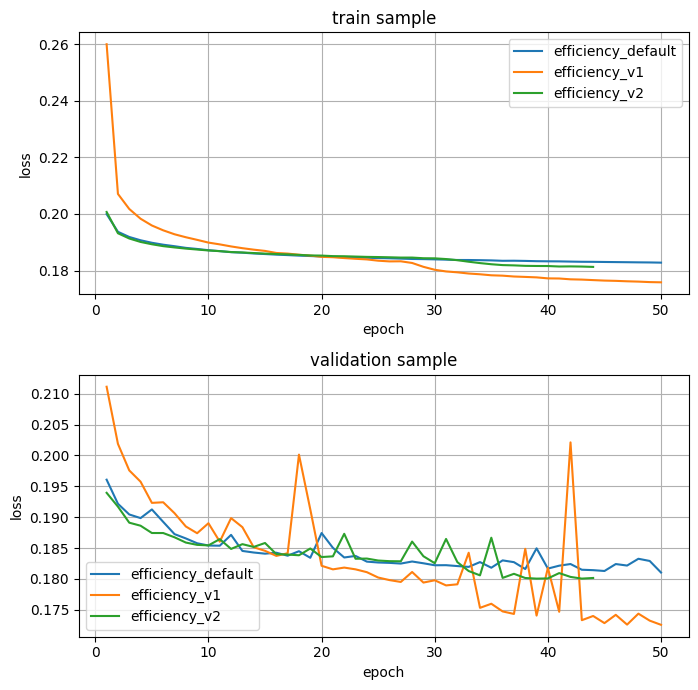

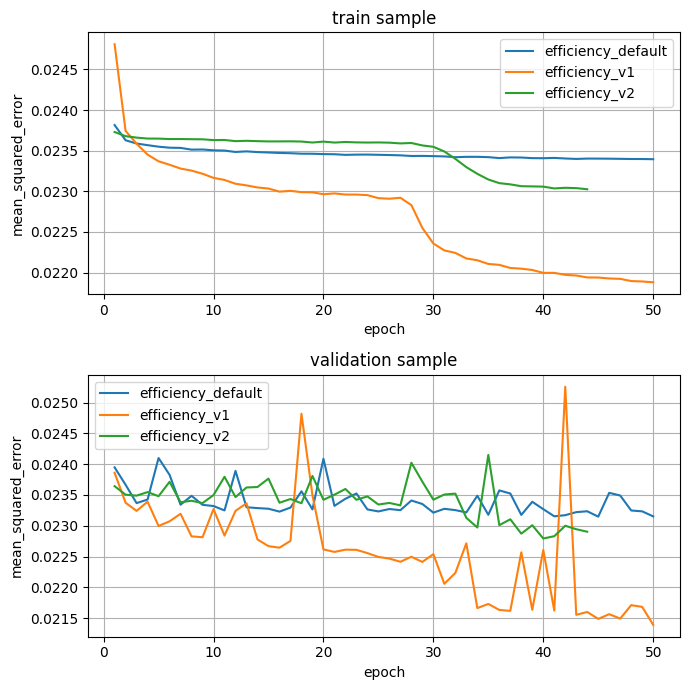

In [12]:
plotHistory(model_variants,metrics=["loss","mean_squared_error"])